In [1]:
import os
import stsynphot as STS
from synphot import SpectralElement, Observation
from synphot import units
import matplotlib.pyplot as plt
import glob
import copy
import synphot
import numpy as np
from scipy.stats import sigmaclip
from astropy import units as u
from synphot import Observation, SpectralElement, SourceSpectrum
from astropy.io import fits,ascii
from astropy.table import Table
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline

In [2]:
#JWST primary mirror area
area = 253260. #25.326 m^2
STS.conf.area = area

In [3]:
#nircam throughput files
thru_files = glob.glob('PySynphot/Jan_2017_exclude0.98reserve_factor/*fits')
thru_files.sort()

In [4]:
#an aside...find the mean gain value in the SW and LW channels. Maybe keep it separate for
#A module and B module and then combine if necessary.
gain_files = glob.glob('*excludingbadfile_gain.fits')

In [5]:
swa = []
swb = []
gain = {}
for file in gain_files:
    with fits.open(file) as h:
        gaindata = h[1].data
    tmp = gaindata[4:2044,4:2044]
    good = np.isfinite(tmp)
    clipped,lo,hi = sigmaclip(tmp[good],low=3,high=3)
    meangain = clipped.mean()
    dr, filename = os.path.split(file)
    det = dr.split('/')[-1]    
    #slash = file.rfind('/')
    #det = file[slash+4:slash+6]
    gain[det] = meangain
    
gain['swa'] = np.mean([gain['A1'],gain['A2'],gain['A3'],gain['A4']])
gain['swb'] = np.mean([gain['B1'],gain['B2'],gain['B3'],gain['B4']])
gain['lwa'] = gain['A5']
gain['lwb'] = gain['B5']
print(gain)

{'lwa': 2.1923525, 'B5': 2.1811192, 'B2': 2.5557644, 'A4': 2.2748423, 'A2': 2.5222762, 'B1': 2.520169, 'swa': 2.4433761, 'A1': 2.4926066, 'B4': 2.3360932, 'swb': 2.4908085, 'lwb': 2.1811192, 'A3': 2.4837794, 'B3': 2.5512073, 'A5': 2.1923525, 'delivery_to_CRDS': 2.3360932}


In [6]:
# Set up for zeropoint outputs
results = Table()
filts = []
realfilt = []
pupil = []
mods = []
dets = []
vegazp = []
stzp = []
abzp = []
flam = []
fnu = []
photom_results = Table()
mjy_str = []
pivot = []
#mypivot = []
pixel_scale = 0.031 #arcsec per pixel
sterrad_per_arcsec2 = (1. / 3600. * np.pi / 180.)**2
str_per_detector = (2040. * pixel_scale**2) * sterrad_per_arcsec2
#str_per_detector = (2040. * pixel_scale / 3600. * np.pi / 180.)**2
pixar_a2 = pixel_scale**2
pixar_sr = pixar_a2 * sterrad_per_arcsec2

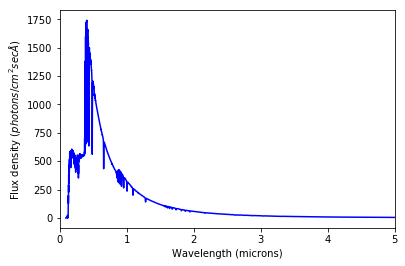

In [7]:
# Get Vega spectrum
vega = SourceSpectrum.from_vega()
vega.waveset / 10000.
f,a = plt.subplots()
a.plot(vega.waveset/10000.,vega.model.lookup_table,color='blue')
a.set_xlim(0,5)
a.set_ylabel(r'Flux density ($photons/cm^2 sec \AA$)')
a.set_xlabel('Wavelength (microns)')
#a.set_yscale('log')
plt.show()
f.savefig('synphot_vega_spectrum.png')

In [8]:
# Filter pairings for filters in the pupil wheel
filter_dict = {'F164N':'150W2','F323N':'F322W2','F405N':'F444W','F466N':'F444W','F470N':'F444W'}

In [9]:
detectors = {}
detectors['swa'] = ['A1','A2','A3','A4']
detectors['swb'] = ['B1','B2','B3','B4']
detectors['lwa'] = ['A5']
detectors['lwb'] = ['B5']

In [10]:
# quick test - SHOWS THAT THE EFFECTS OF GAIN CAN BE INCLUDED IN
# TWO WAYS. FIRST - DIVIDE THE BANDPASS BY THE GAIN AND THEN 
# CALUCATE QUANTITIES. OR SECOND - MULTIPLY PHOTFLAM AND PHOTFNU 
# BY THE GAIN, AND SUBTRACT 2.5*LOG(GAIN) FROM THE ST,AB,VEGAMAG
# ZEROPOINTS

import copy
jwst_area = 25.326 * (u.m * u.m)
my_bins = np.arange(0.5, 5, 0.1) * u.micron

tfile = thru_files[0]
gainval = gain['A1']
bp = SpectralElement.from_file(tfile)

#method #1 - divide bandpass by gain
bp1 = copy.deepcopy(bp)
bp1.model.lookup_table = bp1.model.lookup_table / gainval
photflam1 = bp1.unit_response(jwst_area)
photplam1 = bp1.pivot()
st_zpt1 = -2.5 * np.log10(photflam1.value) - 21.1
ab_zpt1 = (-2.5 * np.log10(photflam1.value) - 21.1 - 5 * np.log10(photplam1.value) + 18.6921)
obs1 = Observation(vega, bp1, binset=my_bins)
vega_zpt1 = -obs1.effstim(flux_unit='obmag', area=jwst_area)
photfnu1 = units.convert_flux(photplam1, photflam1, units.FNU)
print('Divide bandpass: {} {} {} {} {} {}'.format(photflam1,photplam1,st_zpt1,ab_zpt1,vega_zpt1,photfnu1))


#method #2 - divide results by gain
photflam = bp.unit_response(jwst_area)
photplam = bp.pivot()
st_zpt = -2.5 * np.log10(photflam.value) - 21.1 - 2.5*np.log10(gainval)
ab_zpt = (-2.5 * np.log10(photflam.value) - 21.1 - 5 * np.log10(photplam.value) + 18.6921) - 2.5*np.log10(gainval)

jy_zpt = units.convert_flux(photplam,photflam, u.Jy)
print('jansky results: {}'.format(jy_zpt))


obs = Observation(vega, bp, binset=my_bins)
vega_zpt = -obs.effstim(flux_unit='obmag', area=jwst_area)
photfnu = units.convert_flux(photplam, photflam, units.FNU)
print('Divide result: {} {} {} {} {} {}'.format(photflam*gainval,photplam,st_zpt,ab_zpt,vega_zpt.value- 2.5*np.log10(gainval),photfnu*gainval))


Divide bandpass: 8.17544688407794e-20 FLAM 7048.777388183272 Angstrom 26.618721246826794 26.070252271523408 25.776090070713416 OBMAG 1.3549347724585975e-30 FNU
jansky results: 5.435814664016055e-08 Jy
Divide result: 8.17544688407794e-20 FLAM 7048.777388183272 Angstrom 26.61872126175804 26.070252286454654 25.77609008564466 1.3549347724585975e-30 FNU


In [11]:
# Calculate zeropoints in VEGAMAG, ABMAG, STMAG. Also get PHOTFLAM,
# PHOTFNU, PHOTPLAM
jwst_area = 25.326 * (u.m * u.m)
vega = SourceSpectrum.from_vega()
my_bins = np.arange(0.5, 5, 0.1) * u.micron

#loop over throughput files
for tfile in thru_files:
    
    #get filter name, for plot
    compname = fits.getval(tfile,'COMPNAME')
    under = compname.find('_')
    filter = compname[0:under]
    module = compname[-1:].upper()
    
    #for populating the results table later
    filts.append(filter)
    mods.append(module)
    
    #use module and channel to find 
    #appropriate gain value
    fnum = np.int(filter[1:4])
    if fnum < 250:
        chan = 'sw'
    else:
        chan = 'lw'
    chanmod = chan+module.lower()
    gainval = gain[chanmod]
    
    #inputs for photom reference file
    if filter in filter_dict:
        f = filter_dict[filter]
        p = filter
    else:
        f = filter
        p = 'CLEAR'
    realfilt.append(f)
    pupil.append(p)
  
    bp = SpectralElement.from_file(tfile)
    
    #now reduce the PCE curve by a factor equal to
    #the gain, in order to get the output to translate
    #from ADU/sec rather than e/sec
    bp.model.lookup_table = bp.model.lookup_table / gainval

    photflam = bp.unit_response(jwst_area)
    photplam = bp.pivot()

    st_zpt = -2.5 * np.log10(photflam.value) - 21.1
    ab_zpt = (-2.5 * np.log10(photflam.value) - 21.1 - 5 * np.log10(photplam.value) + 18.6921)
    obs = Observation(vega, bp, binset=my_bins)
    vega_zpt = -obs.effstim(flux_unit='obmag', area=jwst_area)
    photfnu = units.convert_flux(photplam, photflam, units.FNU)
        
    vegazp.append('%.4f' % vega_zpt.value)
    abzp.append('%.4f' % ab_zpt)
    stzp.append('%.4f' % st_zpt)
    flam.append('%.4e' % photflam.value)
    fnu.append('%.4e' % photfnu.value)
    pivotmu = photplam.value/10000.
    pivot.append('%.4f' % pivotmu)
    #ANSWER: we need to translate 1 dn/sec into mjy per strrad.
    #photflam - translate to mjy per str
    #mjy_str.append(obs.effstim(flux_unit='Jy').value/1.e6/str_per_detector)

In [12]:
# Organize results
results['Filter'] = filts
results['Module'] = mods
results['VEGAMAG'] = vegazp
results['ABMAG'] = abzp
results['STMAG'] = stzp
results['FLAMBDA'] = flam
results['FNU'] = fnu
results['Pivot_Wavelength'] = pivot

In [13]:
aresults = results['Module'] == 'A'
amod = results[aresults]
bresults = results['Module'] == 'B'
bmod = results[bresults]

In [14]:
amod

<Table length=29>
Filter Module VEGAMAG  ABMAG   STMAG   FLAMBDA      FNU     Pivot_Wavelength
 str6   str1    str7    str7    str7    str10      str10          str6      
------ ------ ------- ------- ------- ---------- ---------- ----------------
 F070W      A 25.7977 26.0919 26.6404 8.0140e-20 1.3282e-30           0.7049
 F090W      A 25.9686 26.4873 27.5746 3.3895e-20 9.2278e-31           0.9034
 F115W      A 25.8419 26.6251 28.2440 1.8299e-20 8.1277e-31           1.1539
 F140M      A 24.8878 25.9980 28.0457 2.1964e-20 1.4482e-30           1.4060
F150W2      A 27.0048 28.2376 30.6445 2.0053e-21 1.8407e-31           1.6589
 F150W      A 25.6536 26.8645 29.0531 8.6851e-21 6.5193e-31           1.5001
 F162M      A 24.6957 26.0540 28.4196 1.5565e-20 1.3754e-30           1.6276
 F164N      A 22.3073 23.7054 26.0938 1.3258e-19 1.1964e-29           1.6447
 F182M      A 24.8258 26.3901 29.0283 8.8852e-21 1.0092e-30           1.8453
 F187N      A 22.1775 23.8063 26.4778 9.3087e-20 1.0902e-29           1.8738
   ...    ...     ...     ...     ...        ...        ...              ...
 F356W      A 24.3778 27.1693 31.2371 1.1619e-21 4.9237e-31           3.5642
 F360M      A 23.4778 26.3159 30.4202 2.4657e-21 1.0806e-30           3.6247
 F405N      A 20.5588 23.6469 27.9924 2.3070e-20 1.2626e-29           4.0506
 F410M      A 23.2749 26.3483 30.7052 1.8964e-21 1.0488e-30           4.0720
 F430M      A 22.3584 25.5354 30.0017 3.6252e-21 2.2174e-30           4.2822
 F444W      A 23.9731 27.1634 31.6811 7.7190e-22 4.9506e-31           4.3849
 F460M      A 21.9502 25.2916 29.9297 3.8736e-21 2.7758e-30           4.6350
 F466N      A 20.0428 23.4245 28.0717 2.1445e-20 1.5496e-29           4.6543
 F470N      A 19.8869 23.2575 27.9297 2.4441e-20 1.8073e-29           4.7083
 F480M      A 21.9002 25.3044 30.0159 3.5781e-21 2.7431e-30           4.7941

In [15]:
# Write results to ASCII and latex tables
amod.write('NIRCam_zeropoints_useArminsGainMethod_modAavg.txt',format='ascii',overwrite=True)
bmod.write('NIRCam_zeropoints_useArminsGainMethod_modBavg.txt',format='ascii',overwrite=True)
amod.write('NIRCam_zeropoints_useArminsGainMethod_modAavg.tex',format='latex',overwrite=True)
bmod.write('NIRCam_zeropoints_useArminsGainMethod_modBavg.tex',format='latex',overwrite=True)

In [17]:
# Reset outputs if you want to run case keeping detectors seperate
# Set up for zeropoint outputs
results = Table()
filts = []
realfilt = []
pupil = []
mods = []
dets = []
vegazp = []
stzp = []
abzp = []
flam = []
fnu = []
photom_results = Table()
mjy_str = []
pivot = []
#mypivot = []
pixel_scale = 0.031 #arcsec per pixel
sterrad_per_arcsec2 = (1. / 3600. * np.pi / 180.)**2
str_per_detector = (2040. * pixel_scale**2) * sterrad_per_arcsec2
#str_per_detector = (2040. * pixel_scale / 3600. * np.pi / 180.)**2
pixar_a2 = pixel_scale**2
pixar_sr = pixar_a2 * sterrad_per_arcsec2

In [18]:
# Calculate zeropoints in VEGAMAG, ABMAG, STMAG. Also get PHOTFLAM,
# PHOTFNU, PHOTPLAM separately for each detector (due to varying gains)
jwst_area = 25.326 * (u.m * u.m)
vega = SourceSpectrum.from_vega()
my_bins = np.arange(0.5, 5, 0.1) * u.micron

#loop over throughput files
for tfile in thru_files:
    
    # create spectral element object from throughput file
    orig_bp = SpectralElement.from_file(tfile)
    
    # get filter name, for plot
    compname = fits.getval(tfile,'COMPNAME')
    under = compname.find('_')
    filter = compname[0:under]
    module = compname[-1:].upper()
        
    # use module and channel to find 
    # appropriate gain values
    fnum = np.int(filter[1:4])
    if fnum < 250:
        chan = 'sw'
    else:
        chan = 'lw'
    chanmod = chan+module.lower()
    
    # each detector has a different mean gain, so
    # we'll have to perform the calculations below
    # on each detector separately
    for detector in detectors[chanmod]:
        bp = copy.deepcopy(orig_bp)
        
        gainval = gain[detector]
        
        #for populating the results table later
        filts.append(filter)
        mods.append(module)
        dets.append(detector)
        
        #inputs for photom reference file
        if filter in filter_dict:
            f = filter_dict[filter]
            p = filter
        else:
            f = filter
            p = 'CLEAR'
        realfilt.append(f)
        pupil.append(p)
    
        # now reduce the PCE curve by a factor equal to
        # the gain, in order to get the output to translate
        # from ADU/sec rather than e/sec
        bp.model.lookup_table = bp.model.lookup_table / gainval

        photflam = bp.unit_response(jwst_area)
        photplam = bp.pivot()

        st_zpt = -2.5 * np.log10(photflam.value) - 21.1
        ab_zpt = (-2.5 * np.log10(photflam.value) - 21.1 - 5 * np.log10(photplam.value) + 18.6921)
        obs = Observation(vega, bp, binset=my_bins)
        vega_zpt = -obs.effstim(flux_unit='obmag', area=jwst_area)
        photfnu = units.convert_flux(photplam, photflam, units.FNU)
        
        vegazp.append('%.4f' % vega_zpt.value)
        abzp.append('%.4f' % ab_zpt)
        stzp.append('%.4f' % st_zpt)
        flam.append('%.4e' % photflam.value)
        fnu.append('%.4e' % photfnu.value)
        pivotmu = photplam.value/10000.
        pivot.append('%.4f' % pivotmu)
        #ANSWER: we need to translate 1 dn/sec into mjy per strrad.
        #photflam - translate to mjy per str
        #mjy_str.append(obs.effstim(flux_unit='Jy').value/1.e6/str_per_detector)

In [19]:
# Organize results
results['Detector'] = dets
results['Filter'] = filts
results['Module'] = mods
results['VEGAMAG'] = vegazp
results['ABMAG'] = abzp
results['STMAG'] = stzp
results['FLAMBDA'] = flam
results['FNU'] = fnu
results['Pivot_Wavelength'] = pivot

In [20]:
aresults = results['Module'] == 'A'
amod = results[aresults]
bresults = results['Module'] == 'B'
bmod = results[bresults]

In [21]:
# Zeropoint tables
amod

<Table length=68>
Detector Filter Module VEGAMAG ...  FLAMBDA      FNU     Pivot_Wavelength
  str2    str6   str1    str7  ...   str10      str10          str6      
-------- ------ ------ ------- ... ---------- ---------- ----------------
      A1  F070W      A 25.7761 ... 8.1754e-20 1.3549e-30           0.7049
      A2  F070W      A 25.7632 ... 8.2728e-20 1.3711e-30           0.7049
      A3  F070W      A 25.7799 ... 8.1465e-20 1.3501e-30           0.7049
      A4  F070W      A 25.8753 ... 7.4612e-20 1.2366e-30           0.7049
      A1  F090W      A 25.9470 ... 3.4578e-20 9.4137e-31           0.9034
      A2  F090W      A 25.9341 ... 3.4990e-20 9.5258e-31           0.9034
      A3  F090W      A 25.9508 ... 3.4456e-20 9.3804e-31           0.9034
      A4  F090W      A 26.0462 ... 3.1557e-20 8.5913e-31           0.9034
      A1  F115W      A 25.8203 ... 1.8667e-20 8.2915e-31           1.1539
      A2  F115W      A 25.8074 ... 1.8889e-20 8.3902e-31           1.1539
     ...    ...    ...     ... ...        ...        ...              ...
      A5  F356W      A 24.3778 ... 1.1619e-21 4.9237e-31           3.5642
      A5  F360M      A 23.4778 ... 2.4657e-21 1.0806e-30           3.6247
      A5  F405N      A 20.5588 ... 2.3070e-20 1.2626e-29           4.0506
      A5  F410M      A 23.2749 ... 1.8964e-21 1.0488e-30           4.0720
      A5  F430M      A 22.3584 ... 3.6252e-21 2.2174e-30           4.2822
      A5  F444W      A 23.9731 ... 7.7190e-22 4.9506e-31           4.3849
      A5  F460M      A 21.9502 ... 3.8736e-21 2.7758e-30           4.6350
      A5  F466N      A 20.0428 ... 2.1445e-20 1.5496e-29           4.6543
      A5  F470N      A 19.8869 ... 2.4441e-20 1.8073e-29           4.7083
      A5  F480M      A 21.9002 ... 3.5781e-21 2.7431e-30           4.7941

In [22]:
bmod

<Table length=68>
Detector Filter Module VEGAMAG ...  FLAMBDA      FNU     Pivot_Wavelength
  str2    str6   str1    str7  ...   str10      str10          str6      
-------- ------ ------ ------- ... ---------- ---------- ----------------
      B1  F070W      B 25.7440 ... 8.4589e-20 1.3974e-30           0.7038
      B2  F070W      B 25.7288 ... 8.5784e-20 1.4172e-30           0.7038
      B3  F070W      B 25.7307 ... 8.5631e-20 1.4147e-30           0.7038
      B4  F070W      B 25.8264 ... 7.8410e-20 1.2954e-30           0.7038
      B1  F090W      B 25.9643 ... 3.4258e-20 9.2811e-31           0.9012
      B2  F090W      B 25.9491 ... 3.4741e-20 9.4122e-31           0.9012
      B3  F090W      B 25.9511 ... 3.4679e-20 9.3954e-31           0.9012
      B4  F090W      B 26.0467 ... 3.1755e-20 8.6032e-31           0.9012
      B1  F115W      B 25.7913 ... 1.9136e-20 8.5102e-31           1.1547
      B2  F115W      B 25.7761 ... 1.9406e-20 8.6304e-31           1.1547
     ...    ...    ...     ... ...        ...        ...              ...
      B5  F356W      B 24.3883 ... 1.1421e-21 4.8620e-31           3.5725
      B5  F360M      B 23.4555 ... 2.5190e-21 1.1033e-30           3.6237
      B5  F405N      B 20.7007 ... 2.0232e-20 1.1084e-29           4.0527
      B5  F410M      B 23.2763 ... 1.8572e-21 1.0375e-30           4.0924
      B5  F430M      B 22.4677 ... 3.2817e-21 2.0055e-30           4.2803
      B5  F444W      B 24.1562 ... 6.6928e-22 4.3637e-31           4.4212
      B5  F460M      B 22.0422 ... 3.5882e-21 2.5599e-30           4.6247
      B5  F466N      B 20.1430 ... 1.9535e-20 1.4117e-29           4.6545
      B5  F470N      B 20.0173 ... 2.1680e-20 1.6024e-29           4.7072
      B5  F480M      B 22.4086 ... 2.3561e-21 1.8363e-30           4.8337

In [23]:
# Write results to ASCII and latex tables
amod.write('NIRCam_zeropoints_useArminsGainMethod_modAdetectors.txt',format='ascii',overwrite=True)
bmod.write('NIRCam_zeropoints_useArminsGainMethod_modBdetectors.txt',format='ascii',overwrite=True)
amod.write('NIRCam_zeropoints_useArminsGainMethod_modAdetectors.tex',format='latex',overwrite=True)
bmod.write('NIRCam_zeropoints_useArminsGainMethod_modBdetectors.tex',format='latex',overwrite=True)

In [24]:
a1results = results['Detector'] == 'A1'
a1mod = results[a1results]
a2results = results['Detector'] == 'A2'
a2mod = results[a2results]
a3results = results['Detector'] == 'A3'
a3mod = results[a3results]
a4results = results['Detector'] == 'A4'
a4mod = results[a4results]
a5results = results['Detector'] == 'A5'
a5mod = results[a5results]

b1results = results['Detector'] == 'B1'
b1mod = results[b1results]
b2results = results['Detector'] == 'B2'
b2mod = results[b2results]
b3results = results['Detector'] == 'B3'
b3mod = results[b3results]
b4results = results['Detector'] == 'B4'
b4mod = results[b4results]
b5results = results['Detector'] == 'B5'
b5mod = results[b5results]

In [25]:
# Write results to ASCII and latex tables
a1mod.write('NIRCam_zeropoints_A1.txt',names=['Detector','Filter','Module','VEGAMAG','ABMAG','STMAG','FLAM','FNU','Pivot_Wavelength'],format='ascii',overwrite=True)
a2mod.write('NIRCam_zeropoints_A2.txt',names=['Detector','Filter','Module','VEGAMAG','ABMAG','STMAG','FLAM','FNU','Pivot_Wavelength'],format='ascii',overwrite=True)
a3mod.write('NIRCam_zeropoints_A3.txt',names=['Detector','Filter','Module','VEGAMAG','ABMAG','STMAG','FLAM','FNU','Pivot_Wavelength'],format='ascii',overwrite=True)
a4mod.write('NIRCam_zeropoints_A4.txt',names=['Detector','Filter','Module','VEGAMAG','ABMAG','STMAG','FLAM','FNU','Pivot_Wavelength'],format='ascii',overwrite=True)
a5mod.write('NIRCam_zeropoints_A5.txt',names=['Detector','Filter','Module','VEGAMAG','ABMAG','STMAG','FLAM','FNU','Pivot_Wavelength'],format='ascii',overwrite=True)
b1mod.write('NIRCam_zeropoints_B1.txt',names=['Detector','Filter','Module','VEGAMAG','ABMAG','STMAG','FLAM','FNU','Pivot_Wavelength'],format='ascii',overwrite=True)
b2mod.write('NIRCam_zeropoints_B2.txt',names=['Detector','Filter','Module','VEGAMAG','ABMAG','STMAG','FLAM','FNU','Pivot_Wavelength'],format='ascii',overwrite=True)
b3mod.write('NIRCam_zeropoints_B3.txt',names=['Detector','Filter','Module','VEGAMAG','ABMAG','STMAG','FLAM','FNU','Pivot_Wavelength'],format='ascii',overwrite=True)
b4mod.write('NIRCam_zeropoints_B4.txt',names=['Detector','Filter','Module','VEGAMAG','ABMAG','STMAG','FLAM','FNU','Pivot_Wavelength'],format='ascii',overwrite=True)
b5mod.write('NIRCam_zeropoints_B5.txt',names=['Detector','Filter','Module','VEGAMAG','ABMAG','STMAG','FLAM','FNU','Pivot_Wavelength'],format='ascii',overwrite=True)

In [8]:
# Filter profile plots for reports

#separate filters by bandwidth class. Also, let's look only at mod A.
w2_list = []
w_list = []
m_list = []
n_list = []
for f in thru_files:
    if 'moda' in f:
        nc = f.rfind('nircam')
        width = f[nc+11:nc+13]
        if width == 'w2':
            w2_list.append(f)
        elif width == 'w_':
            w_list.append(f)
        elif width == 'm_':
            m_list.append(f)
        elif width == 'n_':
            n_list.append(f)
moda_files = w_list + m_list

In [9]:
# Get filter bandpasses for other missions
irac1 = SpectralElement.from_file('irac_channel1_trans_full.txt',wave_unit=u.micron)
irac2 = SpectralElement.from_file('irac_channel2_trans_full.txt',wave_unit=u.micron)
wise1 = SpectralElement.from_file('WISE-W1_throughputs.txt',wave_unit=u.micron)
wise2 = SpectralElement.from_file('WISE-W2_throughputs.txt',wave_unit=u.micron)
#twomassj = SpectralElement.from_file('2MASS_JBand_TotalThroughput.txt',wave_unit=u.micron)
#twomassh = SpectralElement.from_file('2MASS_HBand_TotalThroughput.txt',wave_unit=u.micron)
#twomassk = SpectralElement.from_file('2MASS_KBand_TotalThroughput.txt',wave_unit=u.micron)
twomassj = SpectralElement.from_file('2MASS_JBand_5.0mmH2O_full_throughput.txt',wave_unit=u.micron)
twomassh = SpectralElement.from_file('2MASS_HBand_full_throughput.txt',wave_unit=u.micron)
twomassk = SpectralElement.from_file('2MASS_KsBand_full_throughput.txt',wave_unit=u.micron)
other_bandpasses = {}
other_bandpasses['irac1'] = irac1
other_bandpasses['irac2'] = irac2
other_bandpasses['wise1'] = wise1
other_bandpasses['wise2'] = wise2
other_bandpasses['2massj'] = twomassj
other_bandpasses['2massh'] = twomassh
other_bandpasses['2massk'] = twomassk

In [10]:
# Create bandpass objects for WFC3 filters
wfc3_names = ['f105w','f110w','f125w','f140w','f160w','f098m','f127m','f139m','f153m']
wfc3_bandpasses = {}
for wfc3_filter in wfc3_names:
    wfc3_bandpasses[wfc3_filter.lower()] = STS.band('wfc3,ir,{}'.format(wfc3_filter.lower()))
wfc3_wide1 = ['f110w','f140w']
wfc3_wide2 = ['f105w','f125w','f160w']
wfc3_w1 = []
wfc3_w2 = []
for filt in wfc3_wide1:
    wfc3_w1.append(wfc3_bandpasses[filt])
for filt in wfc3_wide2:
    wfc3_w2.append(wfc3_bandpasses[filt])

In [11]:
# Create filter bandpass objects for NIRCam filters
nrc_names = ['f070w','f090w','f115w','f150w','f200w','f140m','f162m',
             'f182m','f210m','f277w','f356w','f444w','f250m','f300m',
             'f335m','f360m','f410m','f430m','f460m','f480m']
nrc_bandpasses = {}
for nrc_filter in nrc_names:
    nrc_file = [s for s in moda_files if '_'+nrc_filter.lower()+'_' in s][0]
    nrc_bandpasses[nrc_filter.lower()] = SpectralElement.from_file(nrc_file)

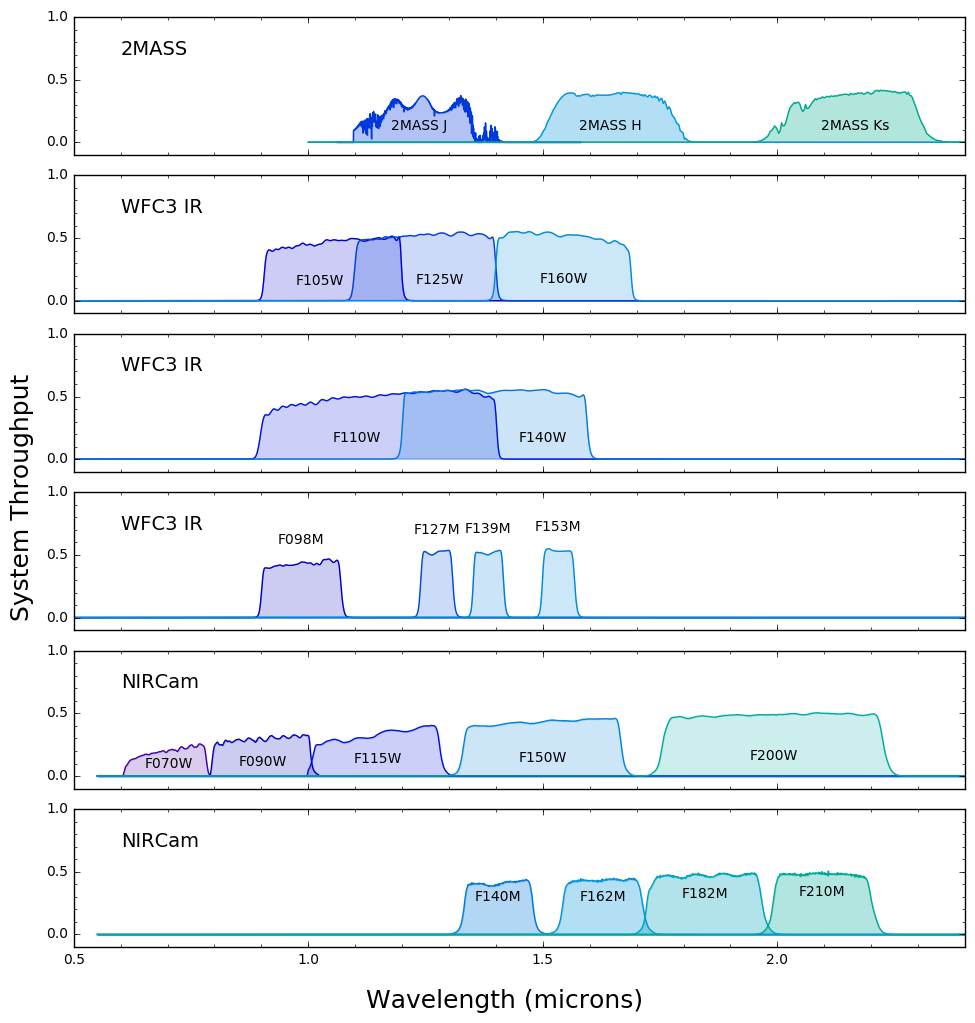

In [26]:
# Bandpass plots - shortwave channel
f,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,sharex=True,sharey=True)
f.set_size_inches(11.5,12)

ax_tm = ax1
ax_nrcw = ax5
ax_nrcm = ax6
ax_wfc3w1 = ax2 
ax_wfc3w2 = ax3
ax_wfc3m = ax4


#set up colors
spectral = cm = plt.get_cmap('spectral') 
cNorm  = colors.Normalize(vmin=0, vmax=5.5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=spectral)

#set up minor tick marks
XminorLocator = MultipleLocator(0.1)
YminorLocator = MultipleLocator(0.1)

#loop through files and read in. Add to plot.   
for file in w_list:
    nc = file.rfind('nircam')
    under = file.find('_',nc+7)
    fname = file[nc+7:under].upper()
    fnum = np.int(fname[1:4])
    if fnum < 241:
        bp = SpectralElement.from_file(file)
        waves = bp.waveset.value / 10000.
        upthrough = bp.model.lookup_table > (0.5*np.max(bp.model.lookup_table))
        midpt = np.median(waves[upthrough])
        colorVal = scalarMap.to_rgba(np.mean(waves[upthrough]))
        ax_nrcw.plot(waves,bp.model.lookup_table,color=colorVal)
        ax_nrcw.fill_between(waves,0,bp.model.lookup_table,color=colorVal,alpha=0.2)
        ax_nrcw.text(midpt-0.05,0.25*np.max(bp.model.lookup_table),fname,color='black')
                
        
#wfc3 wide bands, part 1
for file in wfc3_w1:
    fname = file.obsmode.modes[-1].upper()
    waves = file.waveset.value / 10000.
    fnum = np.int(fname[1:4])
    upthrough = file(file.waveset) > (0.5*np.max(file(file.waveset)))
    midpt = np.median(waves[upthrough])
    colorVal = scalarMap.to_rgba(np.mean(waves[upthrough]))
    ax_wfc3w1.plot(waves,file(file.waveset),color=colorVal)
    ax_wfc3w1.fill_between(waves,0,file(file.waveset),color=colorVal,alpha=0.2)
    offset = 0.05
    if fnum == 105:
        offset = 0.08
    if fnum == 125:
        offset = 0.02
    ax_wfc3w1.text(midpt-offset,0.25*np.max(file(file.waveset)),fname,color='black')

        
#wfc3 wide bands, part 2
for file in wfc3_w2:
    fname = file.obsmode.modes[-1].upper()
    waves = file.waveset.value / 10000.
    fnum = np.int(fname[1:4])
    upthrough = file(file.waveset) > (0.5*np.max(file(file.waveset)))
    midpt = np.median(waves[upthrough])
    colorVal = scalarMap.to_rgba(np.mean(waves[upthrough]))
    ax_wfc3w2.plot(waves,file(file.waveset),color=colorVal)
    ax_wfc3w2.fill_between(waves,0,file(file.waveset),color=colorVal,alpha=0.2)
    if fnum == 110:
        offset = 0.1
    if fnum == 140:
        offset = -0.05
    ax_wfc3w2.text(midpt-offset,0.25*np.max(file(file.waveset)),fname,color='black')


#wfc3 medium, bands
for file in wfc3_m:
    fname = file.obsmode.modes[-1].upper()
    waves = file.waveset.value / 10000.
    upthrough = file(file.waveset) > (0.5*np.max(file(file.waveset)))
    midpt = np.median(waves[upthrough])
    colorVal = scalarMap.to_rgba(np.mean(waves[upthrough]))
    ax_wfc3m.plot(waves,file(file.waveset),color=colorVal)
    ax_wfc3m.fill_between(waves,0,file(file.waveset),color=colorVal,alpha=0.2)
    ax_wfc3m.text(midpt-0.05,1.25*np.max(file(file.waveset)),fname,color='black')
    
    
#add 2MASS JHK to plot
waves = [twomassj.waveset.value/10000.,twomassh.waveset.value/10000.,twomassk.waveset.value/10000.]
thrus = [twomassj.model.lookup_table,twomassh.model.lookup_table,twomassk.model.lookup_table]

#ax_tm.plot(twomassj.waveset.value/10000.,twomassj.model.lookup_table,color='red',label='2MASS J')
#ax_tm.fill_between(twomassj.waveset.value/10000.,0,twomassj.model.lookup_table,color='red',alpha=0.3)
#ax_tm.plot(twomassh.waveset.value/10000.,twomassh.model.lookup_table,color='red',label='2MASS H')
#ax_tm.fill_between(twomassh.waveset.value/10000.,0,twomassh.model.lookup_table,color='red',alpha=0.3)
#ax_tm.plot(twomassk.waveset.value/10000.,twomassk.model.lookup_table,color='red',label='2MASS K')
#ax_tm.fill_between(twomassk.waveset.value/10000.,0,twomassk.model.lookup_table,color='red',alpha=0.3)

jlabs = ['2MASS J','2MASS H','2MASS Ks']
for label,wave,thru in zip(jlabs,waves,thrus):
    upthrough = thru > (0.5*np.max(thru))
    midpt = np.median(wave[upthrough])
    colorVal = scalarMap.to_rgba(np.mean(wave[upthrough]))
    ax_tm.plot(wave,thru,color=colorVal,label=label)
    ax_tm.fill_between(wave,0,thru,color=colorVal,alpha=0.3)
    #offset = 0.05
    ax_tm.text(midpt-0.07,0.1,label,color='black')
      
#hpatterns = ['\\','-','/','\\','-','/','\\','-','/']    
ndelta = [-0.2,-0.14,-0.08,-0.04,-0.07,-0.1,-0.13,-0.1,-0.18,-0.08,-0.1,-0.05]        
for i,file in enumerate(m_list):
    nc = file.rfind('nircam')
    under = file.find('_',nc+7)
    fname = file[nc+7:under].upper()
    fnum = np.int(fname[1:4])
    if fnum < 241:
        bp = SpectralElement.from_file(file)
        waves = bp.waveset.value/10000.
        upthrough = bp.model.lookup_table > (0.5*np.max(bp.model.lookup_table))
        midpt = np.median(waves[upthrough])
        colorVal = scalarMap.to_rgba(np.mean(waves[upthrough]))
        ax_nrcm.plot(waves,bp.model.lookup_table,color=colorVal)
        ax_nrcm.fill_between(waves,0,bp.model.lookup_table,color=colorVal,alpha=0.3)
        ax_nrcm.text(midpt-0.05,0.6*np.max(bp.model.lookup_table),fname,color='black')
                  
#titles for clarity
ax_tm.text(0.6,0.7,'2MASS',color='black',size=14)
ax_nrcw.text(0.6,0.7,'NIRCam',color='black',size=14)
ax_nrcm.text(0.6,0.7,'NIRCam',color='black',size=14)
ax_wfc3w1.text(0.6,0.7,'WFC3 IR',color='black',size=14)
ax_wfc3w2.text(0.6,0.7,'WFC3 IR',color='black',size=14)
ax_wfc3m.text(0.6,0.7,'WFC3 IR',color='black',size=14)
    
#limit the number of y-ticks
ax_tm.set_yticks([0, 0.5, 1])
ax_tm.yaxis.set_minor_locator(YminorLocator)
ax_nrcw.set_yticks([0, 0.5, 1])
ax_nrcw.yaxis.set_minor_locator(YminorLocator)
ax_nrcm.set_yticks([0, 0.5, 1])
ax_nrcm.yaxis.set_minor_locator(YminorLocator)
ax_wfc3w1.set_yticks([0, 0.5, 1])
ax_wfc3w1.yaxis.set_minor_locator(YminorLocator)
ax_wfc3w2.set_yticks([0, 0.5, 1])
ax_wfc3w2.yaxis.set_minor_locator(YminorLocator)
ax_wfc3m.set_yticks([0, 0.5, 1])
ax_wfc3m.yaxis.set_minor_locator(YminorLocator)

#x range and ticks
ax1.set_xlim(0.5,2.4)
ax1.set_xticks(np.arange(0.5,2.4,0.5))
ax1.xaxis.set_minor_locator(XminorLocator)

f.text(0.08, 0.5, 'System Throughput', ha='center', va='center', rotation='vertical',fontsize=18)
f.text(0.5,0.08,'Wavelength (microns)',ha='center', va='center',fontsize=18)
f.subplots_adjust(hspace=0.15)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
f.savefig('FilterProfiles_SW.pdf') 
#plt.show()

/Users/hilbert/anaconda/envs/astroconda27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


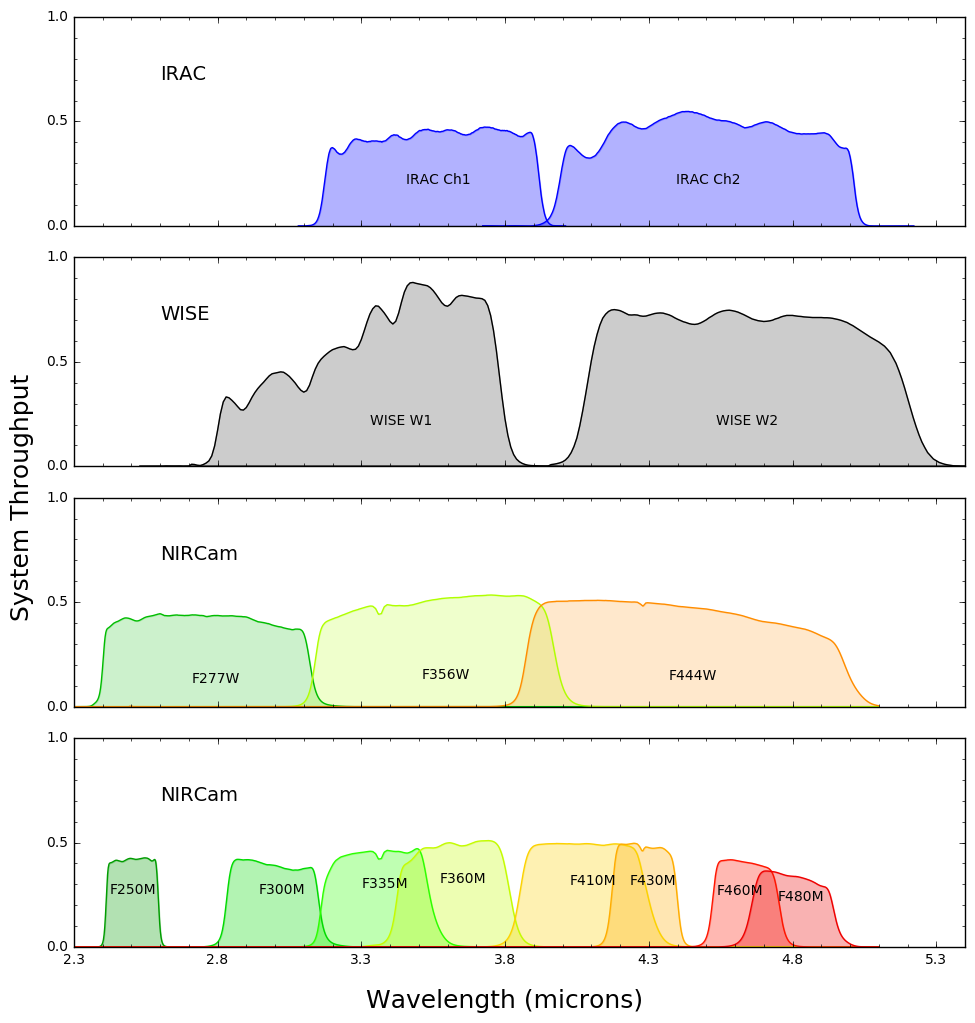

In [28]:
# Longwave channel plot
f,(ax1,ax2,ax3,ax4) = plt.subplots(4,sharex=True,sharey=True)
f.set_size_inches(11.5,12)

#set up colors
spectral = cm = plt.get_cmap('spectral') 
cNorm  = colors.Normalize(vmin=0, vmax=5.5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=spectral)

#set up minor tick marks
XminorLocator = MultipleLocator(0.1)
YminorLocator = MultipleLocator(0.1)

#loop through files and read in. Add to plot.   
for file in w_list:
    nc = file.rfind('nircam')
    under = file.find('_',nc+7)
    fname = file[nc+7:under].upper()
    fnum = np.int(fname[1:4])
    if fnum > 241:
        bp = SpectralElement.from_file(file)
        waves = bp.waveset.value / 10000.
        upthrough = bp.model.lookup_table > (0.5*np.max(bp.model.lookup_table))
        midpt = np.median(waves[upthrough])
        colorVal = scalarMap.to_rgba(np.mean(waves[upthrough]))
        ax3.plot(waves,bp.model.lookup_table,color=colorVal)
        ax3.fill_between(waves,0,bp.model.lookup_table,color=colorVal,alpha=0.2)
        ax3.text(midpt-0.05,0.25*np.max(bp.model.lookup_table),fname,color='black')
                    
#add IRAC filters
ax1.plot(irac1.waveset.value/10000.,irac1.model.lookup_table,color='blue',label='IRAC Ch1')
ax1.fill_between(irac1.waveset.value/10000.,0,irac1.model.lookup_table,color='blue',alpha=0.3)
ax1.plot(irac2.waveset.value/10000.,irac2.model.lookup_table,color='blue',label='IRAC Ch2')
ax1.fill_between(irac2.waveset.value/10000.,0,irac2.model.lookup_table,color='blue',alpha=0.3)
  
clabs = ['IRAC Ch1','IRAC Ch2']
waves = [irac1.waveset.value/10000.,irac2.waveset.value/10000.]
thrus = [irac1.model.lookup_table,irac2.model.lookup_table]
for label,wave,thru in zip(clabs,waves,thrus):
    upthrough = thru > (0.5*np.max(thru))
    midpt = np.median(wave[upthrough])
    offset = 0.05
    vert = 0.2
    ax1.text(midpt-offset,vert,label,color='black')
    
#add WISE filters
ax2.plot(wise1.waveset.value/10000.,wise1.model.lookup_table,color='black')
ax2.fill_between(wise1.waveset.value/10000.,0,wise1.model.lookup_table,color='black',alpha=0.2)
ax2.plot(wise2.waveset.value/10000.,wise2.model.lookup_table,color='black')
ax2.fill_between(wise2.waveset.value/10000.,0,wise2.model.lookup_table,color='black',alpha=0.2)
  
jlabs = ['WISE W1','WISE W2']
waves = [wise1.waveset.value/10000.,wise2.waveset.value/10000.]
thrus = [wise1.model.lookup_table,wise2.model.lookup_table]
for label,wave,thru in zip(jlabs,waves,thrus):
    upthrough = thru > (0.5*np.max(thru))
    midpt = np.median(wave[upthrough])
    offset = 0.1
    ax2.text(midpt-offset,0.2,label,color='black')
      
hpatterns = ['\\','-','/','\\','-','/','\\','-','/']    
ndelta = [-0.2,-0.14,-0.08,-0.04,-0.07,-0.1,-0.13,-0.1,-0.18,-0.08,-0.1,-0.05]        
for i,file in enumerate(m_list):
    nc = file.rfind('nircam')
    under = file.find('_',nc+7)
    fname = file[nc+7:under].upper()
    fnum = np.int(fname[1:4])
    if fnum > 241:
        bp = SpectralElement.from_file(file)
        waves = bp.waveset.value/10000.
        upthrough = bp.model.lookup_table > (0.5*np.max(bp.model.lookup_table))
        midpt = np.median(waves[upthrough])
        colorVal = scalarMap.to_rgba(np.mean(waves[upthrough]))
        ax4.plot(waves,bp.model.lookup_table,color=colorVal)
        ax4.fill_between(waves,0,bp.model.lookup_table,color=colorVal,alpha=0.3)
        hoff = 0.05
        if fnum == 250:
            hoff = 0.08
        elif fnum == 460:
            hoff = 0.1
        ax4.text(midpt-hoff,0.6*np.max(bp.model.lookup_table),fname,color='black')
                  
#titles for clarity
ax1.text(2.6,0.7,'IRAC',color='black',size=14)
ax2.text(2.6,0.7,'WISE',color='black',size=14)
ax3.text(2.6,0.7,'NIRCam',color='black',size=14)
ax4.text(2.6,0.7,'NIRCam',color='black',size=14)
    
#limit the number of y-ticks
ax1.set_yticks([0, 0.5, 1])
ax1.yaxis.set_minor_locator(YminorLocator)
ax2.set_yticks([0, 0.5, 1])
ax2.yaxis.set_minor_locator(YminorLocator)
ax3.set_yticks([0, 0.5, 1])
ax3.yaxis.set_minor_locator(YminorLocator)
ax4.set_yticks([0, 0.5, 1])
ax4.yaxis.set_minor_locator(YminorLocator)

#x range and ticks
ax1.set_xlim(2.3,5.4)
ax1.set_xticks(np.arange(2.3,5.4,0.5))
ax1.xaxis.set_minor_locator(XminorLocator)

#legend
ax4.legend(loc='upper left',fontsize=10)

f.text(0.08, 0.5, 'System Throughput', ha='center', va='center', rotation='vertical',fontsize=18)
f.text(0.5,0.08,'Wavelength (microns)',ha='center', va='center',fontsize=18)
f.subplots_adjust(hspace=0.15)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
f.savefig('lw_filter_profile_comparison.pdf') 
#plt.show()

In [ ]:
# Color transforms

In [12]:
#define a new wavelength set, to allow pysynphot to create spectra that span all the way out to 5.1 microns
nircamwave = np.arange(5000,51000)
col = fits.Column(name='wavelength', unit='angstroms', format='E', array=nircamwave)
tabhdu = fits.BinTableHDU.from_columns([col])
tabhdu.writeto('NIRCam_waveset.fits', clobber=True)

In [13]:
with fits.open('NIRCam_waveset.fits') as pf:
    nircamwave = pf[1].data.field('wavelength')

In [13]:
# Function for delta mag plots - NIRCam filter minus other filter versus blackbody temperature
magoptions = ['vegamag','abmag','stmag']
bb_temps = np.arange(1500,6500,100)
#possible inputs for "other" filter: irac1,irac2,wise1,wise2,twomassj,twomassh,twomassk

def bb_deltamag(nrc_filt,filt,filt_name,magsys):
    if magsys in magoptions:
        pass
    else:        
        print('No valid magnitude system given.')
        stophere
    
    nrc_filt = nrc_filt.lower()
    nrc_file = [s for s in moda_files if '_'+nrc_filt+'_' in s][0]
    
    delta = []
    for bbtemp in bb_temps:
        compare_obs = Observation(SourceSpectrum(synphot.BlackBodyNorm1D, temperature=bbtemp),filt,binset=nircamwave,force='extrap')
        #test = SourceSpectrum(synphot.BlackBodyNorm1D, temperature=bbtemp)
        #print(bbtemp,np.max(test.waveset),np.min(test.waveset),np.max(filt.waveset),np.min(filt.waveset))
        bp_nrc = SpectralElement.from_file(nrc_file)
        nircam_obs = Observation(SourceSpectrum(synphot.BlackBodyNorm1D, temperature=bbtemp),bp_nrc,binset=nircamwave,force='extrap')
        mk = compare_obs.effstim(magsys)
        nc = nircam_obs.effstim(magsys)
        delta.append(nc.value-mk.value)
        
    figgy,aggy = plt.subplots()
    figgy.set_size_inches(9,7)
    aggy.plot(bb_temps,delta,'ro')
    aggy.set_xlabel('Blackbody Temperature (K)')
    aggy.set_ylabel('Delta Magnitude')
    aggy.set_title(magsys.upper()+': '+nrc_filt.upper()+' - '+filt_name)
    plt.show()
    figgy.savefig('mag_'+magsys+'_'+nrc_filt+'_'+'_'+filt_name+'.pdf')
    return delta

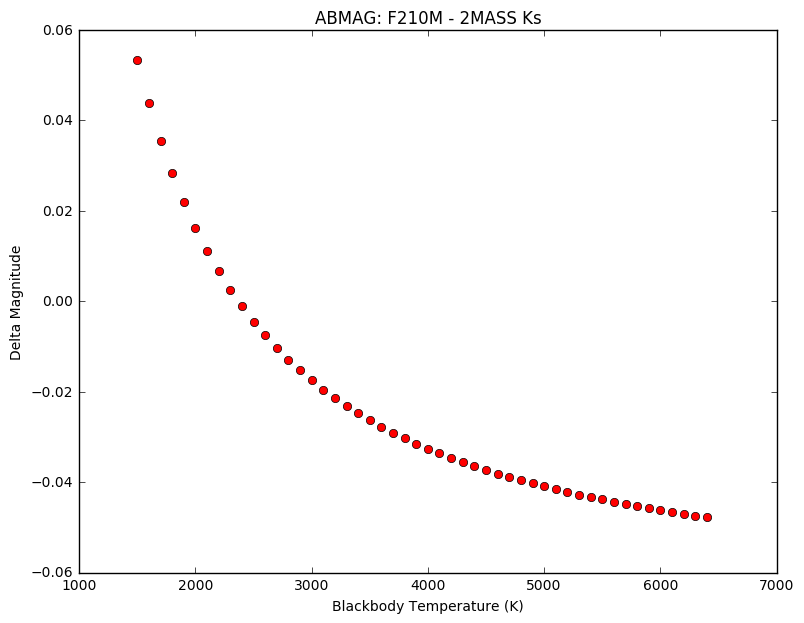

In [45]:
# Delta mag plots versus blackbody temperature
#d = bb_deltamag('F356W',irac1,'IRAC Ch1','abmag')
#d = bb_deltamag('F356W',wise1,'WISE W1','abmag')
#d = bb_deltamag('F444W',irac2,'IRAC Ch2','abmag')
#d = bb_deltamag('F444W',wise2,'WISE W2','abmag')
#d = bb_deltamag('F360M',irac1,'IRAC Ch1','abmag')
#d = bb_deltamag('F200W',twomassk,'2MASS Ks','abmag')
#d = bb_deltamag('F150W',twomassh,'2MASS H','abmag')
#d = bb_deltamag('F115W',twomassj,'2MASS J','abmag')
#d = bb_deltamag('F162M',twomassh,'2MASS H','abmag')
d = bb_deltamag('F210M',twomassk,'2MASS Ks','abmag')

In [14]:
# List of stellar models (recommended by Castelli & Kurucz) to simulate
# various stellar types
ck_stellar_types = ascii.read('stellar_type_models.list')

In [15]:
# Turn a list of stellar model parameters into a list of 
# stsynphot sources
def ck_sources(source_descr,temperature,log_g,metallicity):
    slist = []
    stype = []
    stemp = []
    sgrav = []
    smetal = []
    for descr,temp,g,metal in zip(source_descr,temperature,log_g,metallicity):
        try:
            slist.append(STS.grid_to_spec('ck04models',temp,metal,g))
            stype.append(descr)
            stemp.append(temp)
            sgrav.append(g)
            smetal.append(metal)
            #print("Worked: temp: {}, metal: {}, gravity: {}".format(temp,metal,g))
        except:
            #print("Didn't work: temp: {}, metal: {}, gravity: {}".format(temp,metal,g))
            pass
    return stype,slist,stemp,sgrav,smetal

In [16]:
num = len(ck_stellar_types['temp'].data)
stellar_type, stellar_list, stellar_temp, stellar_grav, stellar_metal = ck_sources(ck_stellar_types['stellar_type'],ck_stellar_types['temp'].data,ck_stellar_types['logg'].data,np.zeros(num))

In [17]:
# Create a list of blackbody source objects
bb_temps = np.arange(1500,6500,100)
bb_list = []
for temp in bb_temps:
    bb_list.append(SourceSpectrum(synphot.BlackBodyNorm1D, temperature=temp))

In [23]:
# Get info about the sources, to help with plotting later
def src_info(source):
    meta = source.meta['expr']
    paren = meta.find('(')
    if paren != -1:
        typ = meta[0:paren]
        if typ == 'bb':
            srctype = 'blackbody'
        elif typ == 'ck04models':
            srctype = 'Castelli-Kurucz'
        elif typ == 'k93models':
            srctype = 'Kurucz Atlas'
    else:
        typ = None
        srctype = None
                
    if srctype == 'bb':
        teff = meta[paren+1:-1]
        metal = None
        grav = None
    elif srctype in ['ck04models','k93models']:
        teffstr = meta.find('T_eff')
        z = meta.find('Z')
        loggstr = meta.find('log_g')
        eparen = meta.find(')')
        teff = meta[teffstr+6:z-1]
        grav = meta[loggstr+6:eparen]
        metal = meta[z+2:loggstr-1]
    else:
        teff = None
        metal = None
        grav = None
    return teff,metal,grav    

In [42]:
# Create a source list containing spectra of various stellar models
# These sources can then be fed into various color color functions
metals = [0]
#temps = [39999,15400,8200,6440,5770,4350,3500]
#gravs = [1,2,3,3.92,4.04,4.29,4.34,4.49,4.54,4.94]
temps = [5860,5770,5570]
gravs = [4.49]




source_list = []
source_temp = []
source_grav = []
source_metal = []
for temp in temps:
    for metal in metals:
        for grav in gravs:
            try:
                #source_list.append(STS.grid_to_spec('k93models', temp, metal, grav))
                source_list.append(STS.grid_to_spec('ck04models',temp,metal,grav))
                source_temp.append(temp)
                source_grav.append(grav)
                source_metal.append(metal)
                print("Worked: temp: {}, metal: {}, gravity: {}".format(temp,metal,grav))
            except:
                print("Didn't work: temp: {}, metal: {}, gravity: {}".format(temp,metal,grav))
                pass

Worked: temp: 5860, metal: 0, gravity: 4.49
Worked: temp: 5770, metal: 0, gravity: 4.49
Worked: temp: 5570, metal: 0, gravity: 4.49


In [18]:
# Base function for calculating a magnitude of a given
# source through a given filter in a given magnitude system
magoptions = ['abmag','stmag']
def get_mag(filt,source,magsys):
    if magsys in magoptions:
        pass
    else:        
        print('No valid magnitude system given.')
        stophere

    obs = Observation(source,filt,binset=nircamwave,force='extrap')
    mag = obs.effstim(magsys)
    return mag.value

In [49]:
#OLD - NOT USED

# Function to calculate values for a color-color plot with 
# two NIRCam filters on the y axis and two filters from
# another instrument on the x axis
#bb_temps = np.arange(1500,6500,100)
#possible inputs for "other" filter: irac1,irac2,wise1,wise2,twomassj,twomassh,twomassk

def colorcolor(nrc_filt1,nrc_filt2,ofilt1,ofilt2,sources,magsys):
    if magsys.lower() in magoptions:
        pass
    else:        
        print('No valid magnitude system given.')
        stophere
    
    nrc_filt1 = nrc_filt1.lower()
    nrc_file1 = [s for s in moda_files if '_'+nrc_filt1+'_' in s][0]
    bp_nrc1 = SpectralElement.from_file(nrc_file1)
    nrc_filt2 = nrc_filt2.lower()
    nrc_file2 = [s for s in moda_files if '_'+nrc_filt2+'_' in s][0]
    bp_nrc2 = SpectralElement.from_file(nrc_file2)
    
    nrc1= []
    nrc2 = []
    o1 = []
    o2 = []
    srctype = []
    srctemp = []
    srcgrav = []
    srcmetal = []
    #for bbtemp in bb_temps:
    for source in sources:
        #bb = SourceSpectrum(synphot.BlackBodyNorm1D, temperature=bbtemp)
        #nrc1.append(get_mag(bp_nrc1,bb,magsys))
        #nrc2.append(get_mag(bp_nrc2,bb,magsys))
        #o1.append(get_mag(ofilt1,bb,magsys))
        #o2.append(get_mag(ofilt2,bb,magsys))
        try:
            nrc1.append(get_mag(bp_nrc1,source,magsys))
            nrc2.append(get_mag(bp_nrc2,source,magsys))
            o1.append(get_mag(ofilt1,source,magsys))
            o2.append(get_mag(ofilt2,source,magsys))
          
            # get info on the sources for later plotting
            meta = source.meta['expr']
            paren = meta.find('(')
            if paren != -1:
                typ = meta[0:paren]
                if typ == 'bb':
                    srctype.append('blackbody')
                elif typ == 'ck04models':
                    srctype.append('Castelli-Kurucz')
                elif typ == 'k93models':
                    srctype.append('Kurucz Atlas')
            else:
                typ = None
                srctype.append('None')
                
            if srctype == 'bb':
                teff = meta[paren+1:-1]
                metal = None
                grav = None
            elif srctype in ['ck04models','k93models']:
                teffstr = meta.find('T_eff')
                z = meta.find('Z')
                loggstr = meta.find('log_g')
                eparen = meta.find(')')
                teff = meta[teffstr+6:z-1]
                grav = meta[loggstr+6:eparen]
                metal = meta[z+2:loggstr-1]
            else:
                teff = None
                metal = None
                grav = None
            
            srctemp.append(teff)
            srcgrav.append(grav)
            srcmetal.append(metal)
        except:
            nrc1.append(np.nan)
            nrc2.append(np.nan)
            o1.append(np.nan)
            o2.append(np.nan)
            srctemp.append(np.nan)
            srcgrav.append(np.nan)
            srcmetal.append(np.nan)
            
    srcinfo = [srctype,srctemp,srcgrav,srcmetal]
    nrc1 = np.array(nrc1)
    nrc2 = np.array(nrc2)
    o1 = np.array(o1)
    o2 = np.array(o2)
    #deltanrc = nrc1-nrc2
    #deltao = o1-o2
    #return deltanrc,deltao  
    return nrc1,nrc2,o1,o2,srcinfo

In [19]:
# Calculate magnitudes for multiple sources using a single filter. 
# Input filter is a bandpass object, sources is a list of source objects,
# magsys is the magnitude system to use
#
# Returns lists of magnitudes, as well as information on the input
# sources (to make later plotting easier, and keep the info list
# current if any of the filter/source observations happend to file
# For example if the source spectrum doesn't overlap the filter passband.
# Currently the source info is limited to blackbody and stellar models

def get_mags(filt,sources,magsys):
    if magsys.lower() in magoptions:
        pass
    else:        
        print('No valid magnitude system given.')
        stophere
        
    mags = []
    for source in sources:
        try:
            mags.append(get_mag(filt,source,magsys))          
        except:
            mags.append(np.nan)
    mags = np.array(mags)
    return mags

In [20]:
# Now create magnitude lists of the blackbody and stellar model 
# sources through each of the filters 
wfc3_bb_mags = {}
wfc3_stellar_mags = {}
for filter in wfc3_bandpasses:
    wfc3_bb_mags[filter] = get_mags(wfc3_bandpasses[filter],bb_list,'abmag')
    wfc3_stellar_mags[filter] = get_mags(wfc3_bandpasses[filter],stellar_list,'abmag')
    
nrc_bb_mags = {}
nrc_stellar_mags = {}
for filter in nrc_bandpasses:
    nrc_bb_mags[filter] = get_mags(nrc_bandpasses[filter],bb_list,'abmag')
    nrc_stellar_mags[filter] = get_mags(nrc_bandpasses[filter],stellar_list,'abmag')
    
other_bb_mags = {}
other_stellar_mags = {}
for filter in other_bandpasses:
    other_bb_mags[filter] = get_mags(other_bandpasses[filter],bb_list,'abmag')
    other_stellar_mags[filter] = get_mags(other_bandpasses[filter],stellar_list,'abmag')

In [21]:
# Define some plotting functions
#stellar_list, stellar_type
#bb_list, bb_temps
def deltamag(mag1,mag2,filter1,filter2,temperature,stype,magsys):
    f,a = plt.subplots()
    if stype.lower() not in ['blackbody','stellar_model']:
        print("Only 'blackbody' and 'stellar_model' allowed for stype")
        return
    elif stype.lower() == 'blackbody':
        a.set_xlabel('Blackbody Temperature (K)')
    elif stype.lower() == 'stellar_model':
        a.set_xlabel('Stellar Model Temperature (K)')
    
    a.plot(temperature,mag1-mag2,'ro')
    f.set_size_inches(9,7)
    a.set_ylabel('Delta Magnitude')
    a.set_title(magsys.upper()+': '+filter1.upper()+' - '+filter2.upper())
    plt.show()
    f.savefig('deltamag_'+magsys+'_'+filter1.strip().replace('/','').replace(' ','')+'_'+filter2.replace('/','').replace(' ','')+'.pdf')

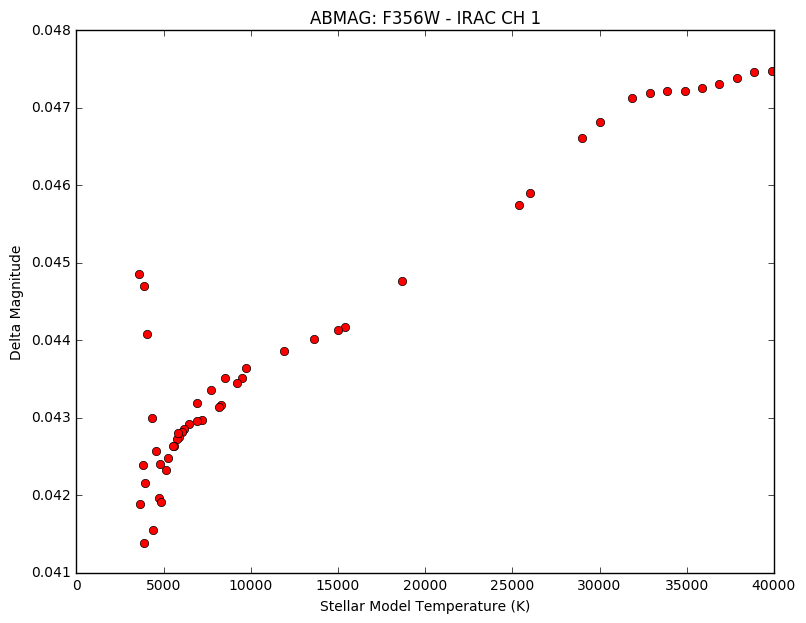

In [30]:
deltamag(nrc_stellar_mags['f356w'],other_stellar_mags['irac1'],'F356W','IRAC Ch 1',stellar_temp,'stellar_model','abmag')

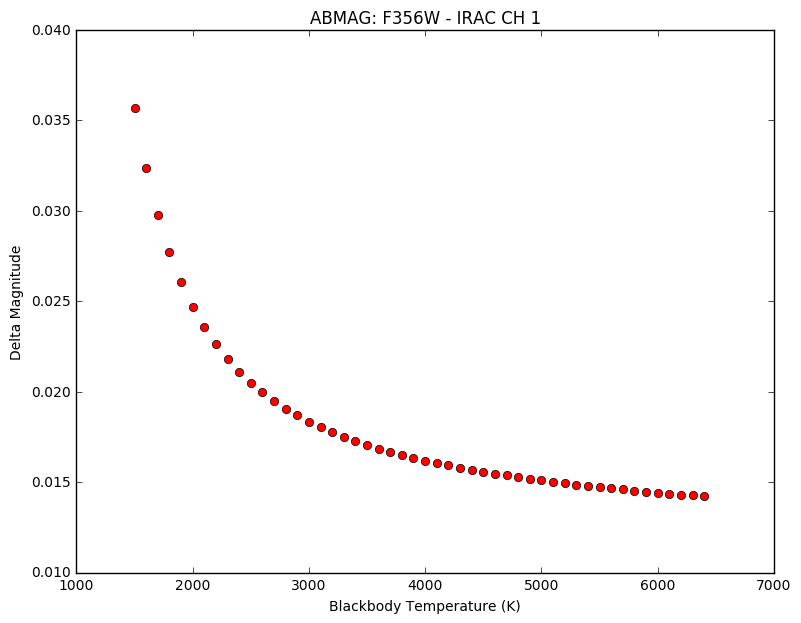

In [33]:
deltamag(nrc_bb_mags['f356w'],other_bb_mags['irac1'],'F356W','IRAC Ch 1',bb_temps,'blackbody','abmag')

In [22]:
# Function to create a color-color plot
#stellar_type
#bb_temps
def colorcolor(mag1,mag2,mag3,mag4,filter1,filter2,filter3,filter4,labels,magsys,stype):
    if 'blackbody' in stype.lower():
        colors = cmx.rainbow(np.linspace(1, 0, len(mag1)))
    else:
        vlen = 0
        ilen = 0
        iiilen = 0
        for lab in labels:
            if lab[-2:].lower() == 'ii':
                iiilen += 1
            elif lab[-1].lower() == 'i':
                ilen += 1
            else:
                vlen += 1
        vcolors = cmx.rainbow(np.linspace(0, 1, vlen))
        icolors = cmx.rainbow(np.linspace(0, 1, ilen))
        iiicolors = cmx.rainbow(np.linspace(0, 1, iiilen))
        
    f,a = plt.subplots()
    dx = mag1 - mag2
    dy = mag3 - mag4
    symbol = '8'
    vcount = 0
    icount = 0
    iiicount = 0
    for i in range(len(dx)):
        if 'blackbody' not in stype.lower():
            #kluge to get diff't symbols for diff't stellar types
            suffix=''
            if ((labels[i][-1] == 'I') & (labels[i][-2] != 'I')):
                symbol = '8'
                plotcolor = icolors[icount] 
                icount += 1
            elif 'III' in labels[i]:
                symbol = 's'
                plotcolor = iiicolors[iiicount]
                iiicount += 1
            else:
                symbol = 'v'
                plotcolor = vcolors[vcount]
                vcount += 1
        else:
            suffix = ' K'
            plotcolor = colors[i]
        if ((np.isfinite(dx[i])) & (np.isfinite(dy[i]))):
            a.scatter(dx[i],dy[i],color=plotcolor,label=str(labels[i])+suffix,marker=symbol)
    f.set_size_inches(9,7)
    origxlim = a.get_xlim()
    deltalim = origxlim[1] - origxlim[0]
    a.set_xlim(origxlim[0],origxlim[0]+deltalim*1.3)
    
    miny = np.nanmin(dy)
    maxy = np.nanmax(dy)
    delta = np.abs(maxy - miny)
    a.set_ylim(miny-0.1*delta,maxy+0.1*delta)
    a.set_xlabel("{} - {}".format(filter1.upper(),filter2.upper()))
    a.set_ylabel("{} - {}".format(filter3.upper(),filter4.upper()))
    a.legend(loc='best',scatterpoints=1,fontsize=8,ncol=2)
    a.set_title("{}: {}".format(magsys.upper(),stype))
    plt.show()
    f.savefig('colorplot_{}_{}minus{}_versus_{}minus{}_{}.pdf'.format(magsys,filter3.replace('/','').replace(' ',''),filter4.replace('/','_').replace(' ',''),filter1.replace('/','_').replace(' ',''),filter2.replace('/','_').replace(' ',''),stype.replace(' ','')))

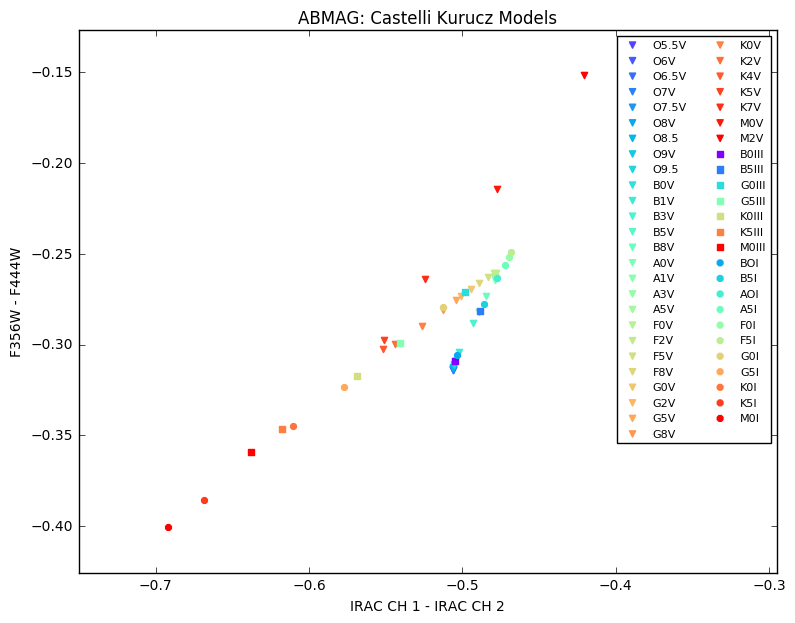

In [48]:
colorcolor(other_stellar_mags['irac1'],other_stellar_mags['irac2'],nrc_stellar_mags['f356w'],nrc_stellar_mags['f444w'],'IRAC Ch 1','IRAC Ch 2','F356W','F444W',stellar_type,'abmag','Castelli Kurucz Models')

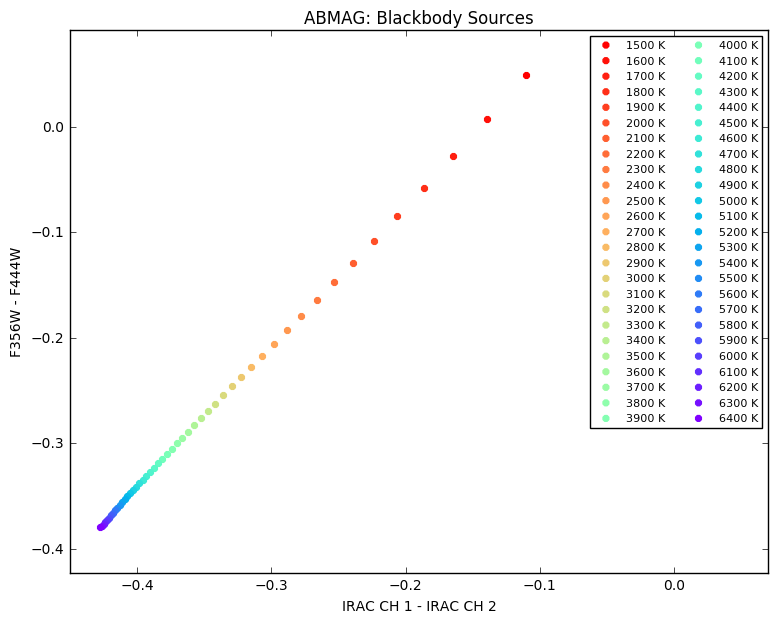

In [35]:
colorcolor(other_bb_mags['irac1'],other_bb_mags['irac2'],nrc_bb_mags['f356w'],nrc_bb_mags['f444w'],'IRAC Ch 1','IRAC Ch 2','F356W','F444W',bb_temps,'abmag','Blackbody Sources')

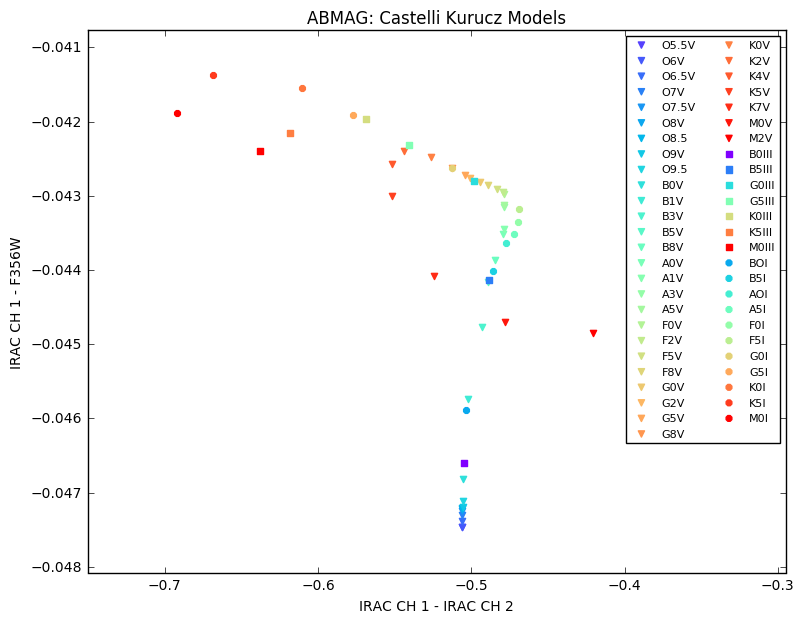

In [36]:
# color color plot for use in identifying nircam magnitude (i.e. use only 1 nircam filter)
colorcolor(other_stellar_mags['irac1'],other_stellar_mags['irac2'],other_stellar_mags['irac1'],nrc_stellar_mags['f356w'],'IRAC Ch 1','IRAC Ch 2','IRAC Ch 1','F356W',stellar_type,'abmag','Castelli Kurucz Models')

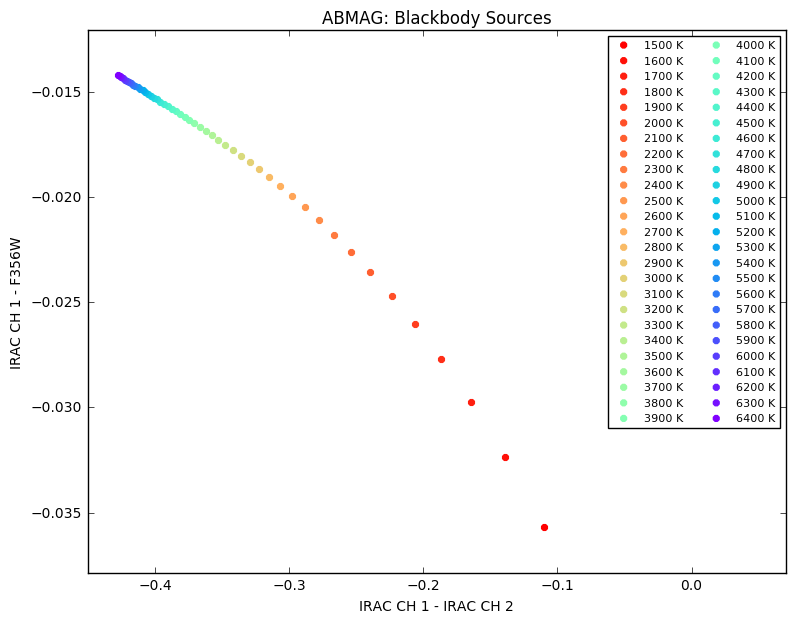

In [24]:
colorcolor(other_bb_mags['irac1'],other_bb_mags['irac2'],other_bb_mags['irac1'],nrc_bb_mags['f356w'],'IRAC Ch 1','IRAC Ch 2','IRAC Ch 1','F356W',bb_temps,'abmag','Blackbody Sources')

In [66]:
nrc_filt1 = 'F356W'
nrc_filt2 = 'F444W'
ofilt1 = irac1
ofilt2 = irac2
bb_f356, bb_f444, bb_irac1, bb_irac2, bb_info = colorcolor(nrc_filt1,nrc_filt2,ofilt1,ofilt2,bb_list,'abmag')

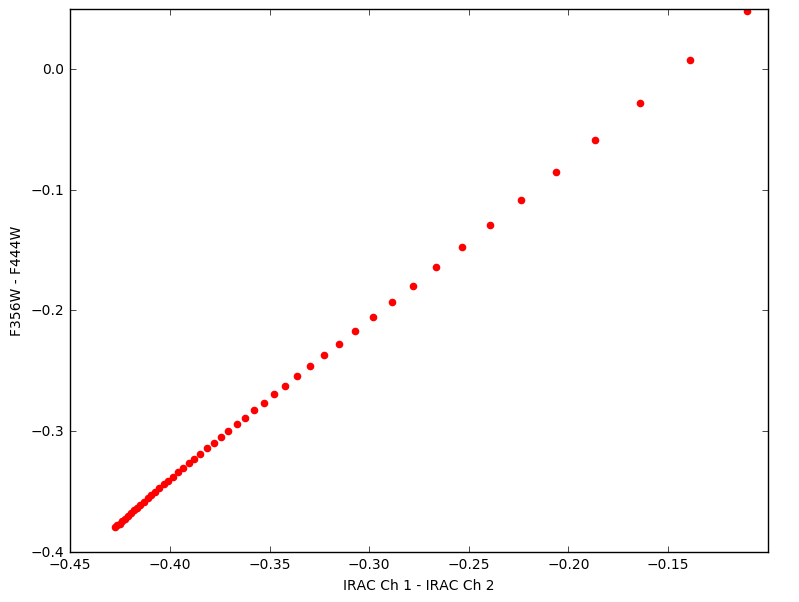

In [73]:
f,a = plt.subplots()
a.scatter(bb_irac1-bb_irac2,bb_f356-bb_f444,color='red')
a.set_xlabel('IRAC Ch 1 - IRAC Ch 2')
a.set_ylabel("F356W - F444W")
f.set_size_inches(9,7)
a.set_xlim(-0.45,-0.1)
a.set_ylim(-0.40,0.05)
plt.show()

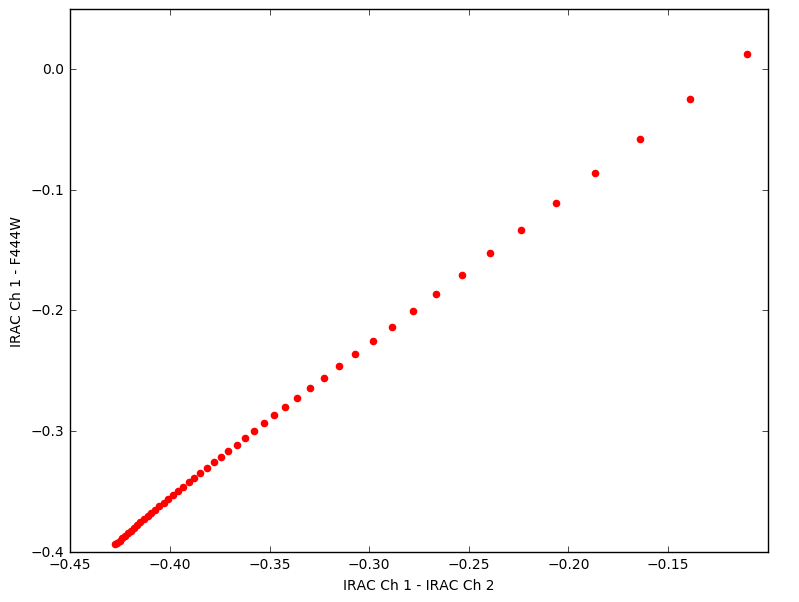

In [75]:
f,a = plt.subplots()
a.scatter(bb_irac1-bb_irac2,bb_irac1-bb_f444,color='red')
a.set_xlabel('IRAC Ch 1 - IRAC Ch 2')
a.set_ylabel("IRAC Ch 1 - F444W")
f.set_size_inches(9,7)
a.set_xlim(-0.45,-0.1)
a.set_ylim(-0.40,0.05)
plt.show()

In [50]:
nrc_filt1 = 'F356W'
nrc_filt2 = 'F444W'
ofilt1 = irac1
ofilt2 = irac2
stellartypes_f356, stellartypes_f444, stellartypes_irac1, stellartypes_irac2, stellartype_info = colorcolor(nrc_filt1,nrc_filt2,ofilt1,ofilt2,stellar_list,'abmag')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/hilbert/anaconda/envs/astroconda27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/hilbert/anaconda/envs/astroconda27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/Users/hilbert/anaconda/envs/astroconda27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/hilbert/anaconda/envs/astroconda27/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/Users/hilbert/anaconda/envs/astroconda27/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/Users/hilbert/anaconda/envs/astroconda27/lib/p

IndexError: string index out of range

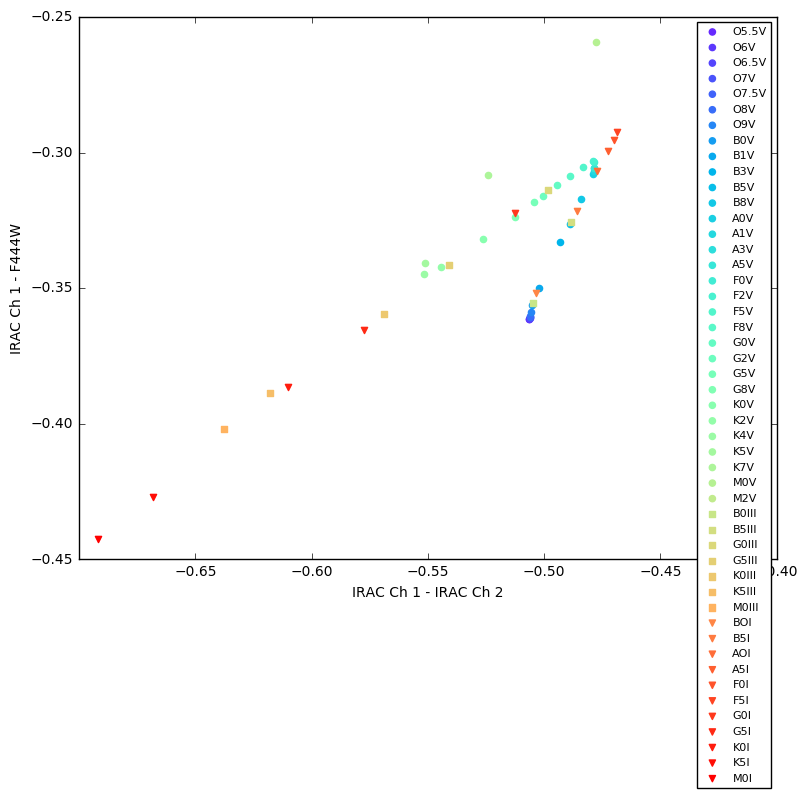

In [72]:
colors = cmx.rainbow(np.linspace(0, 1, len(stellartypes_irac1)))
f,a = plt.subplots()
for i in range(len(stellartypes_irac1)):
#for i in range(3):
    if ((np.isfinite(stellartypes_irac1[i])) & ('V' in stellar_type[i])):
        a.scatter(stellartypes_irac1[i]-stellartypes_irac2[i],stellartypes_irac1[i]-stellartypes_f444[i],color=colors[i],label=stellar_type[i])
    if ((np.isfinite(stellartypes_irac1[i])) & ('III' in stellar_type[i])):
        a.scatter(stellartypes_irac1[i]-stellartypes_irac2[i],stellartypes_irac1[i]-stellartypes_f444[i],color=colors[i],marker='s',label=stellar_type[i])
    if ((np.isfinite(stellartypes_irac1[i])) & (stellar_type[i][-1] == 'I') & (stellar_type[i][-2] != 'I')):
        a.scatter(stellartypes_irac1[i]-stellartypes_irac2[i],stellartypes_irac1[i]-stellartypes_f444[i],color=colors[i],marker='v',label=stellar_type[i])
        
a.set_xlabel('IRAC Ch 1 - IRAC Ch 2')
a.set_ylabel("IRAC Ch 1 - F444W")
a.legend(loc='best',fontsize=8,scatterpoints=1)
f.set_size_inches(9,7)
a.set_xlim(-0.70,-0.4)
a.set_ylim(-0.45,-0.25)
f.savefig('irac1_2_vs_f444w.pdf')
plt.show()

In [57]:
stellar_type

['O3V',
 'O4V',
 'O5V',
 'O5.5V',
 'O6V',
 'O6.5V',
 'O7V',
 'O7.5V',
 'O8V',
 'O8.5',
 'O9V',
 'O9.5',
 'B0V',
 'B1V',
 'B3V',
 'B5V',
 'B8V',
 'A0V',
 'A1V',
 'A3V',
 'A5V',
 'F0V',
 'F2V',
 'F5V',
 'F8V',
 'G0V',
 'G2V',
 'G5V',
 'G8V',
 'K0V',
 'K2V',
 'K4V',
 'K5V',
 'K7V',
 'M0V',
 'M2V',
 'B0III',
 'B5III',
 'G0III',
 'G5III',
 'K0III',
 'K5III',
 'M0III',
 'O5I',
 'O6I',
 'O8I',
 'BOI',
 'B5I',
 'AOI',
 'A5I',
 'F0I',
 'F5I',
 'G0I',
 'G5I',
 'K0I',
 'K5I',
 'M0I']

In [62]:
i=0
print(np.isfinite(stellartypes_irac1[i]-stellartypes_irac2[i]),stellartypes_irac1[i]-stellartypes_f444[i])
print(stellar_type[i])

(False, nan)
O3V


In [ ]:
# List of filter pairs to compare
#
#   Other         NIRCam
# WFC3/F098M      F090W
# WFC3/F139M      F140M
# ??WFC3/F140W    F150W
# ??WFC3/F110W    F115W
# WFC3/F160W      F150W
# ??WFC3/F105W    F115W
# ??WFC3/F125W    F115W
# 2MASS J         F115W
# ??2MASS H       F162M
# 2MASS K         F210M
# IRAC Ch 1       F356W
# IRAC Ch 2       F444W
# WISE 1          F356W
# WISE 2          F444W

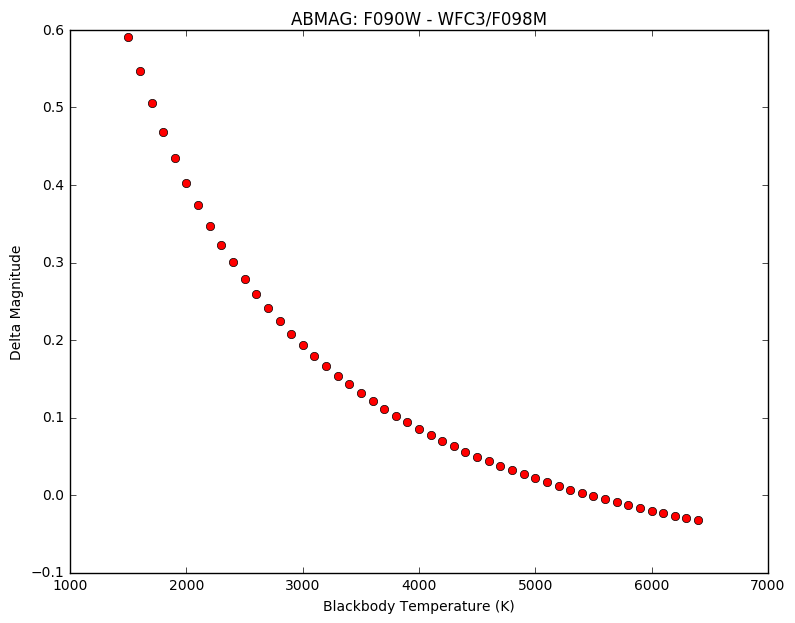

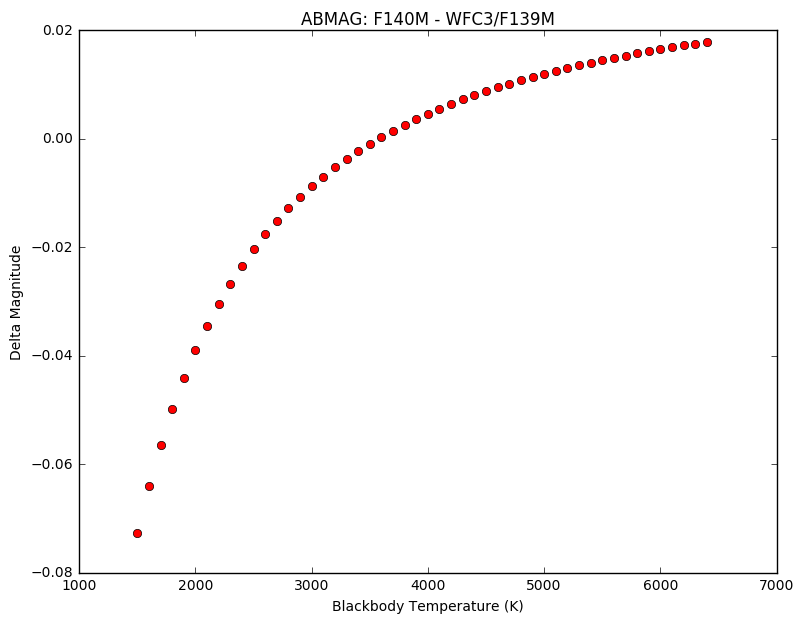

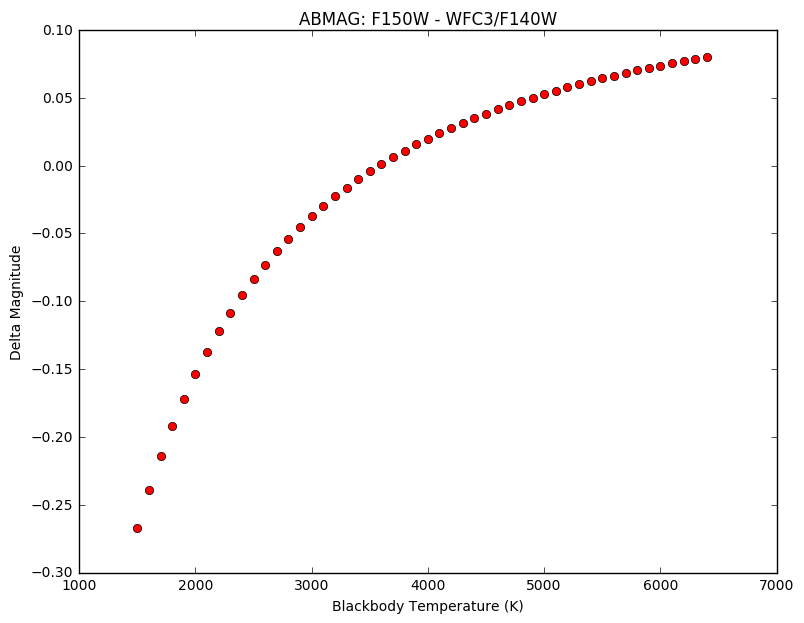

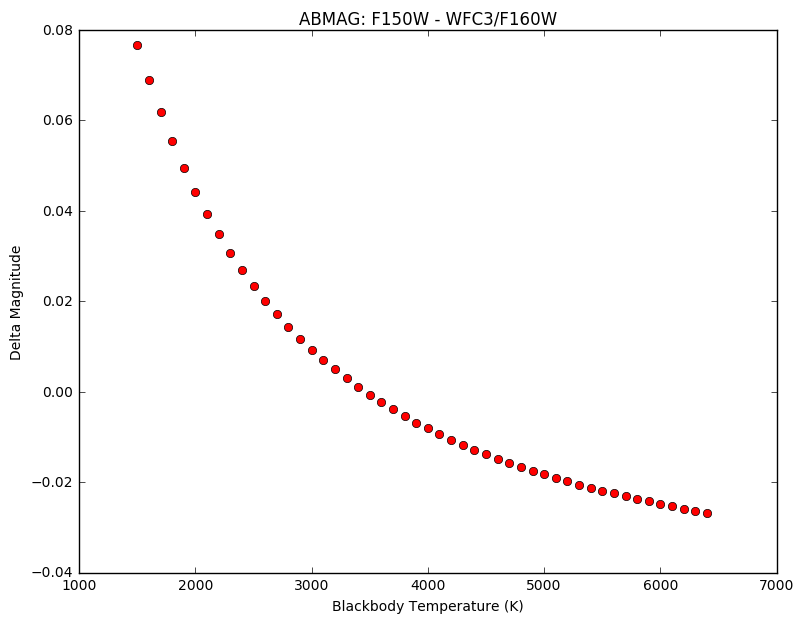

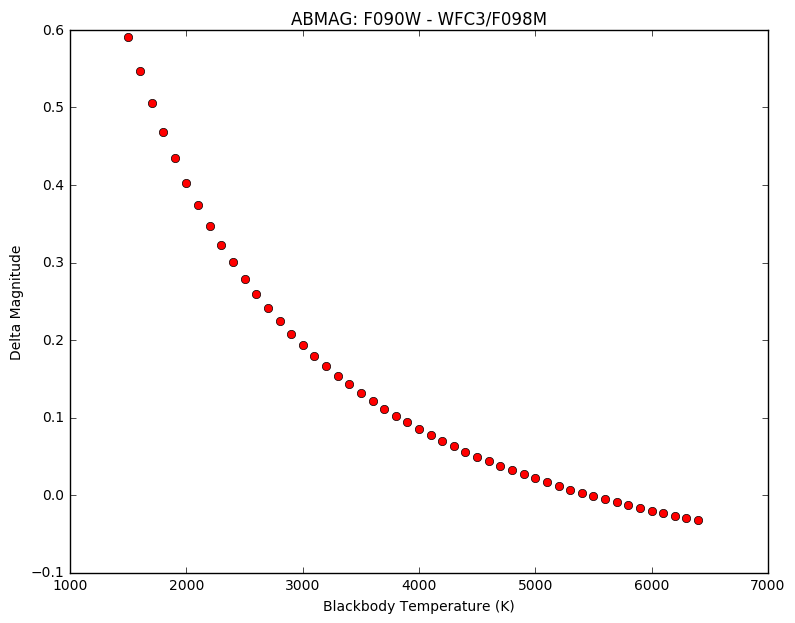

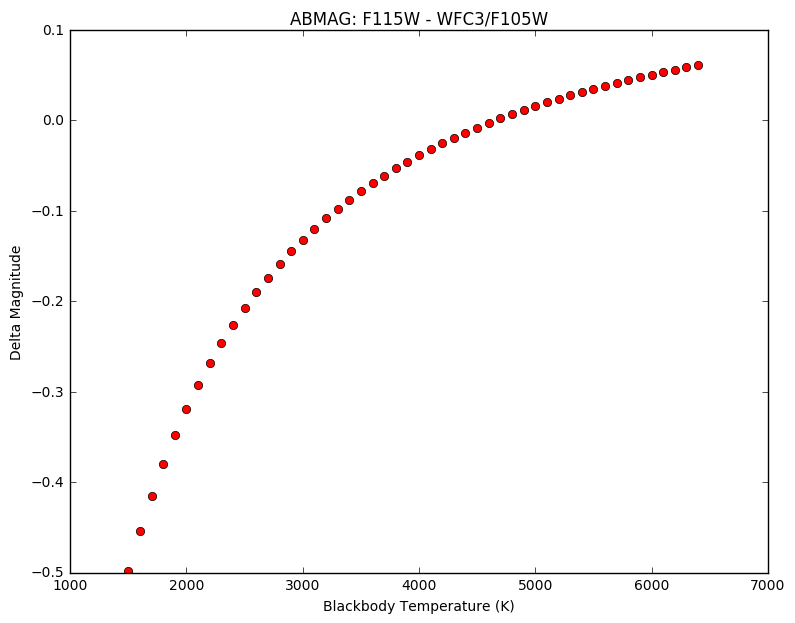

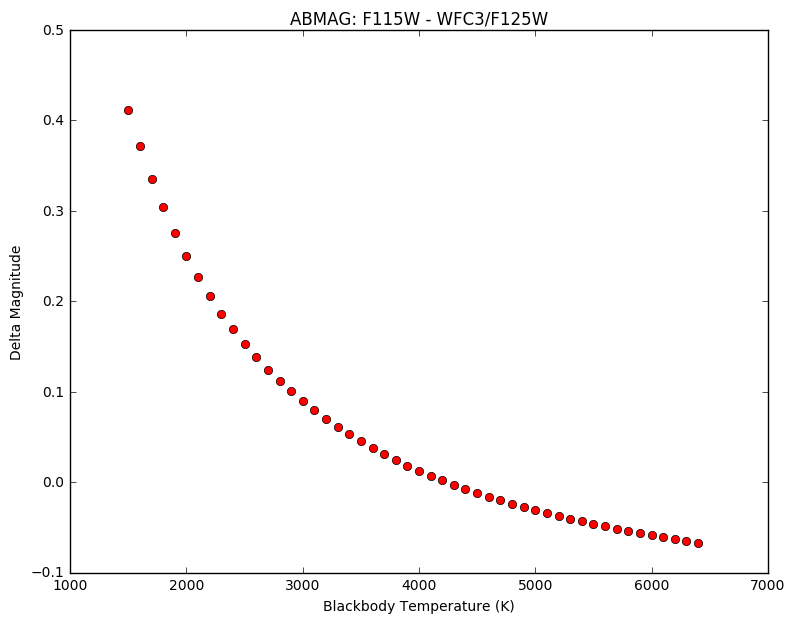

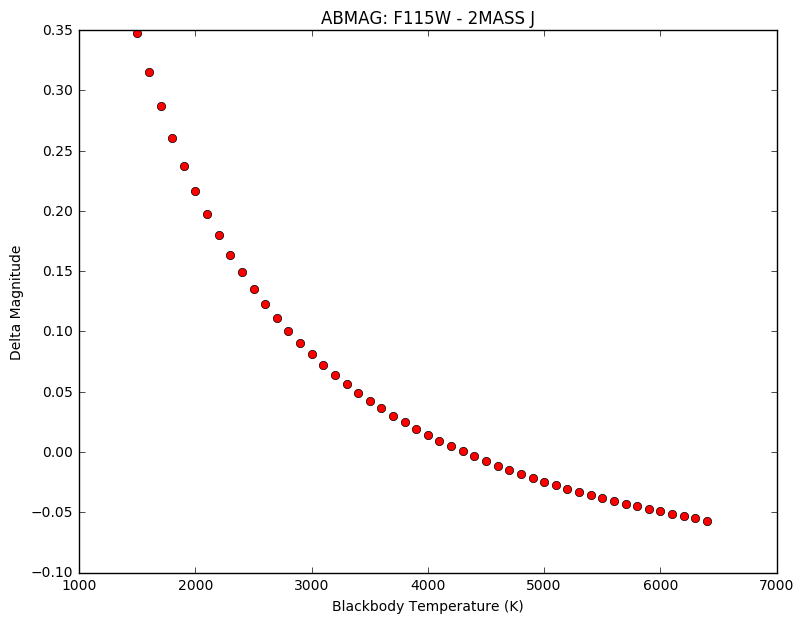

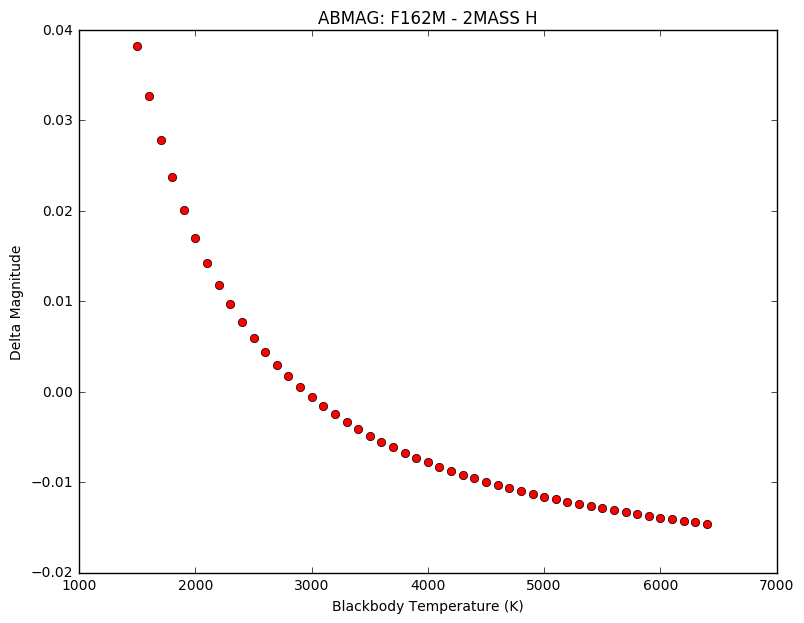

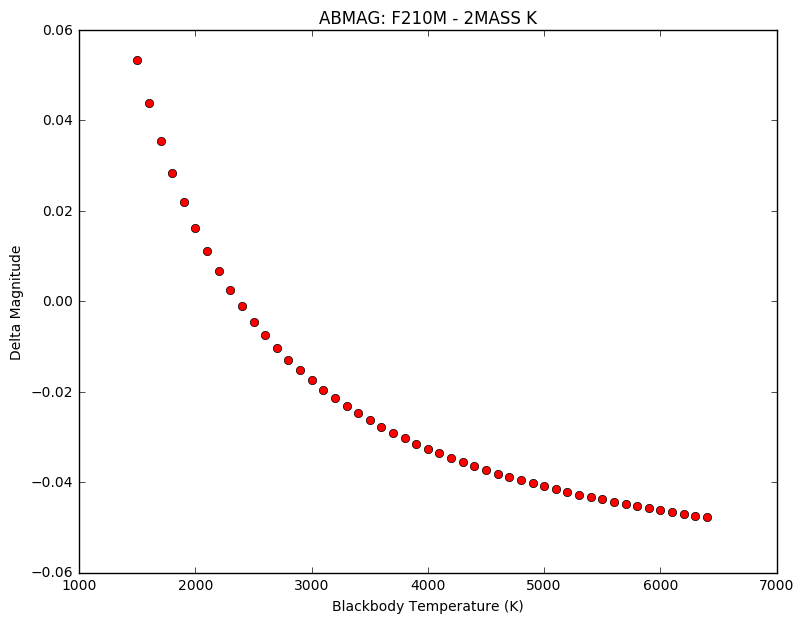

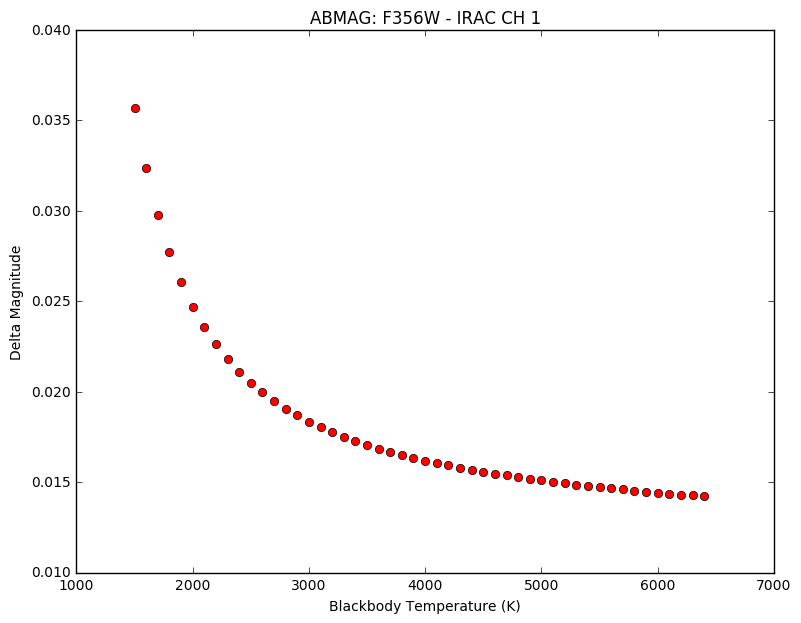

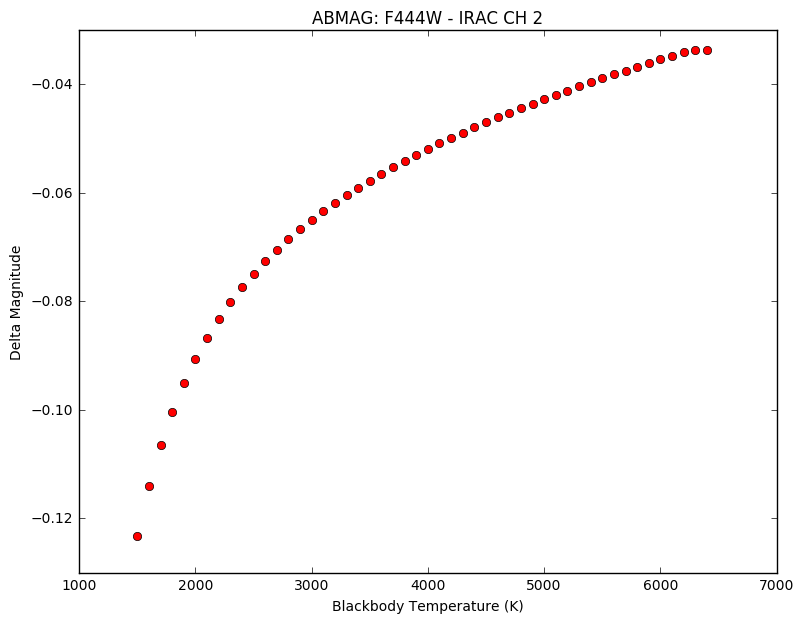

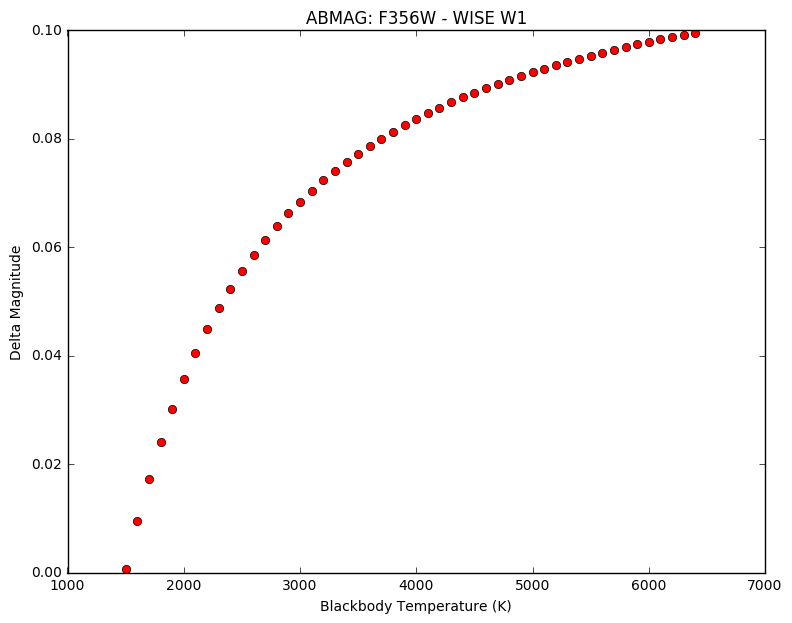

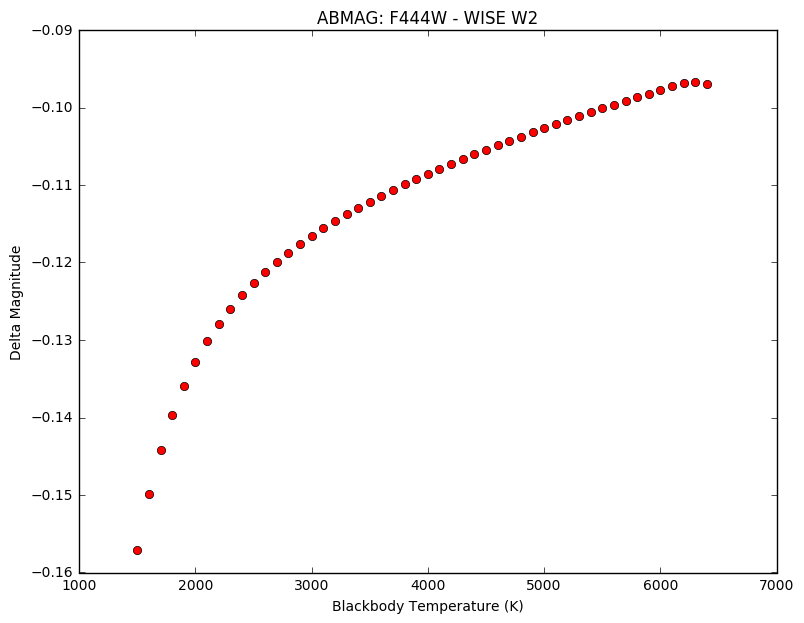

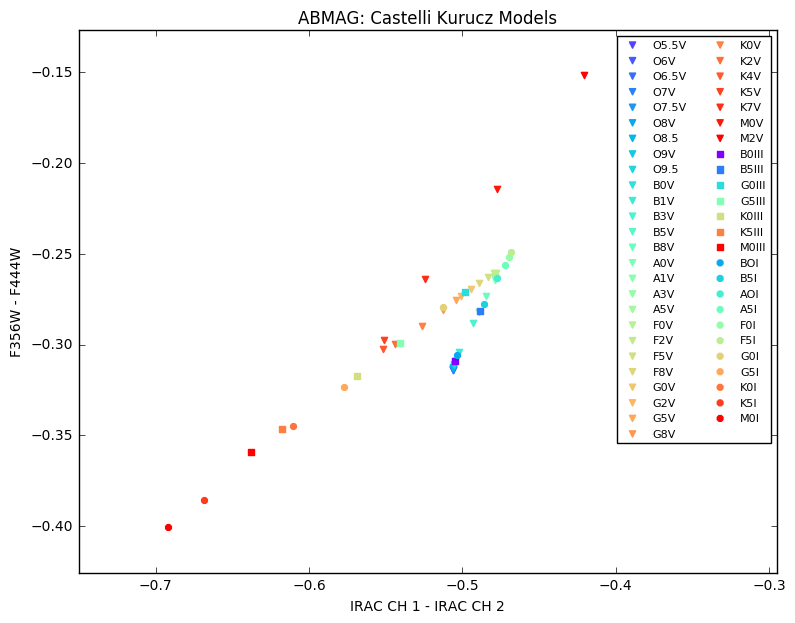

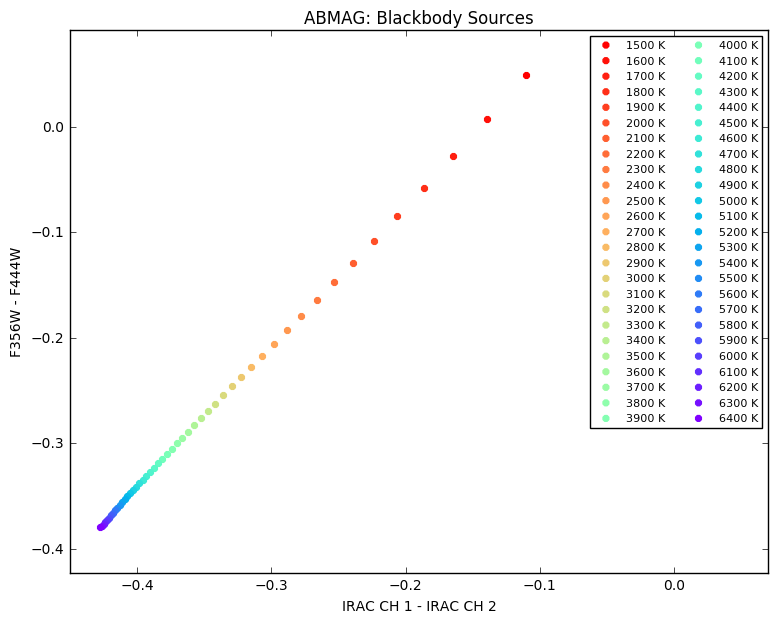

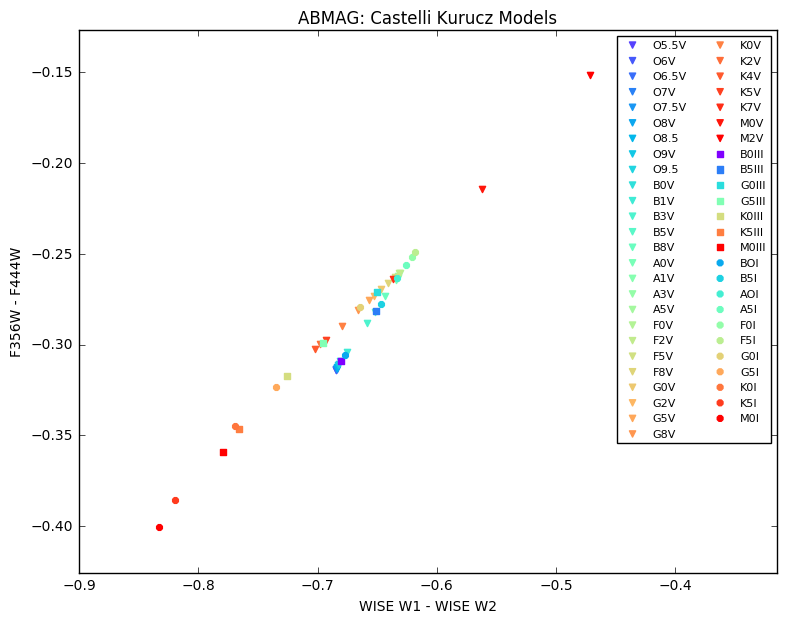

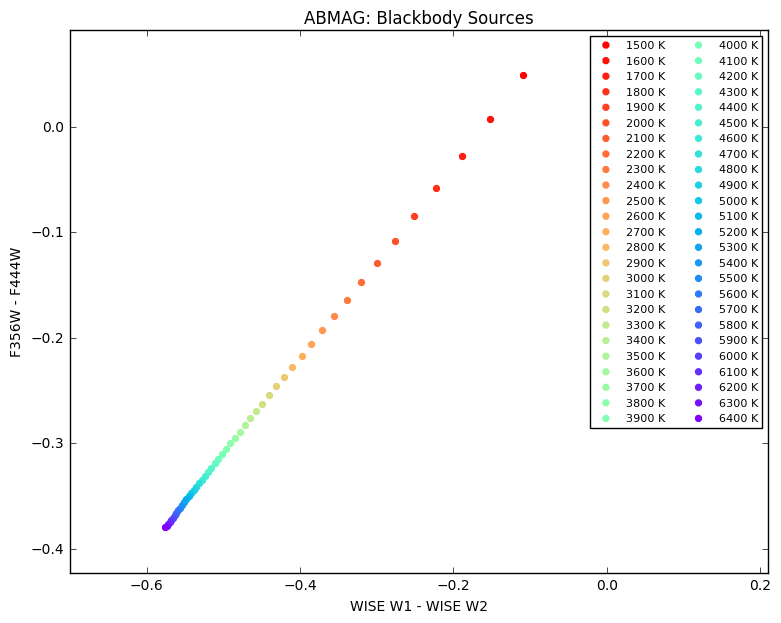

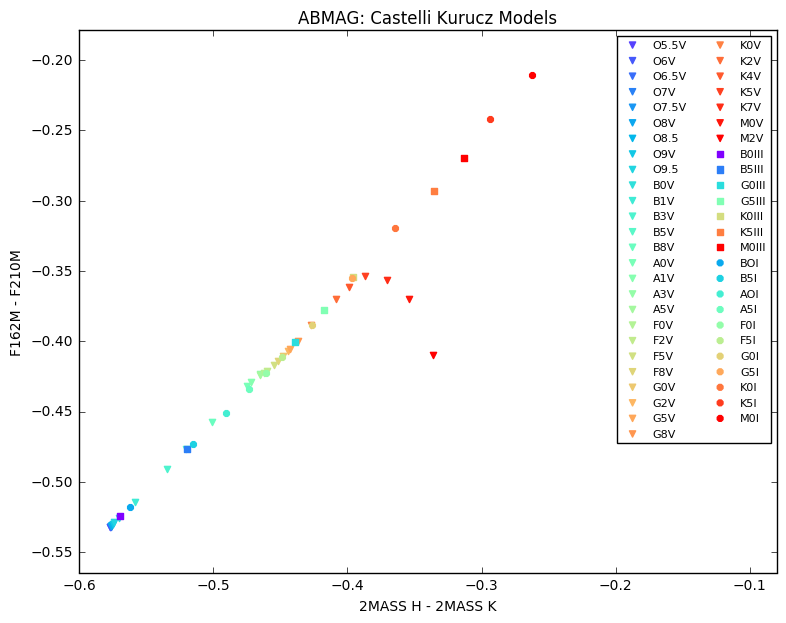

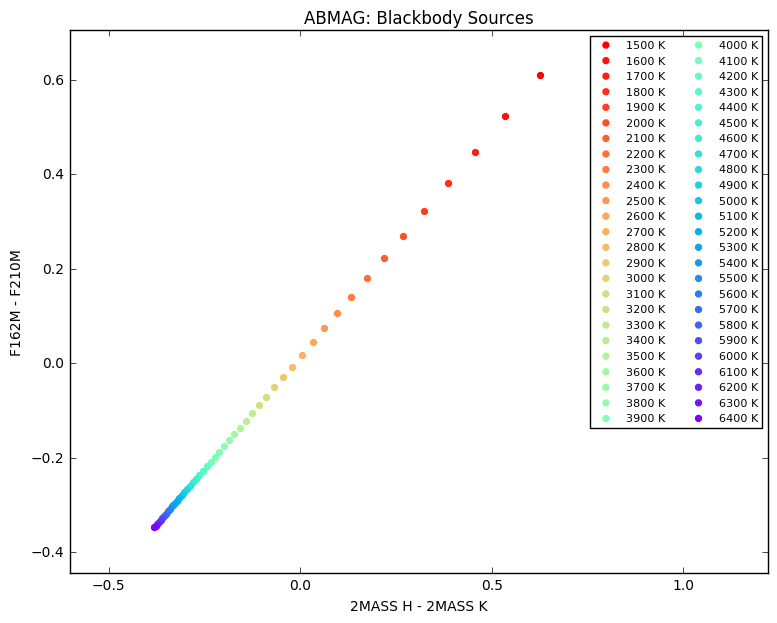

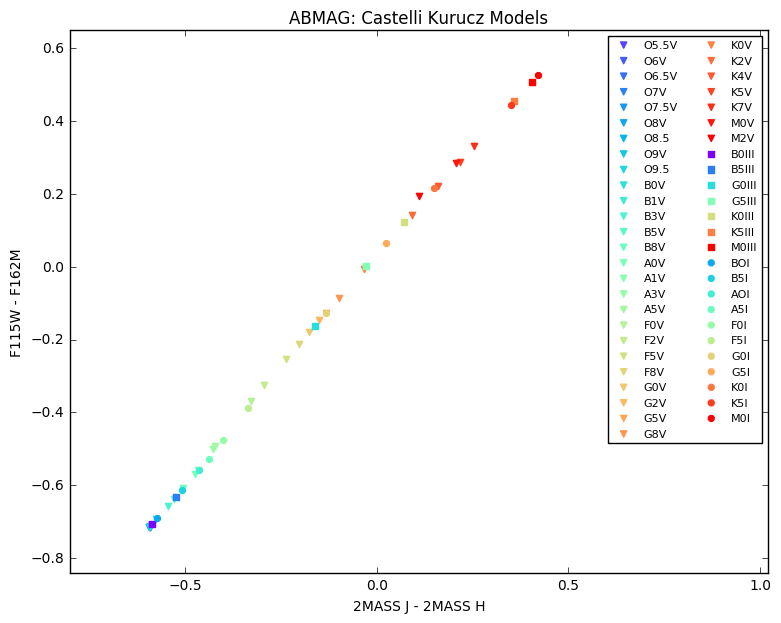

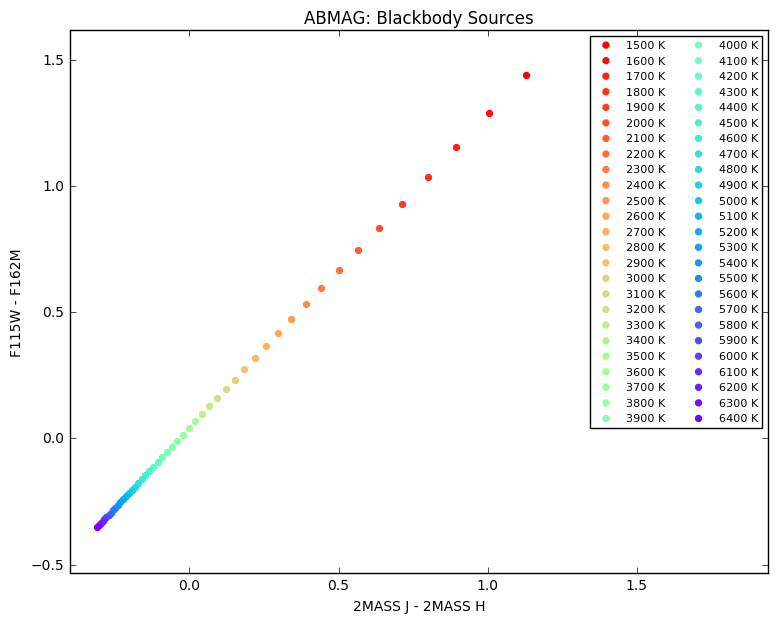

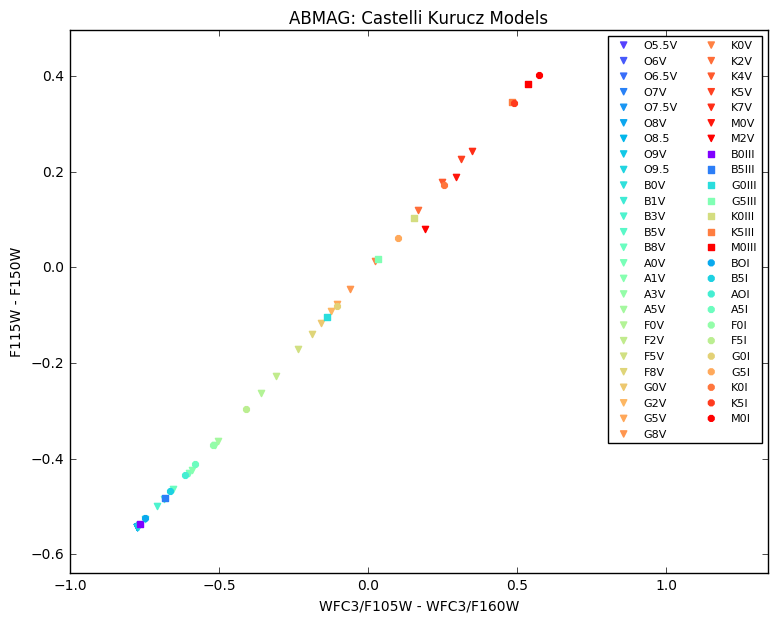

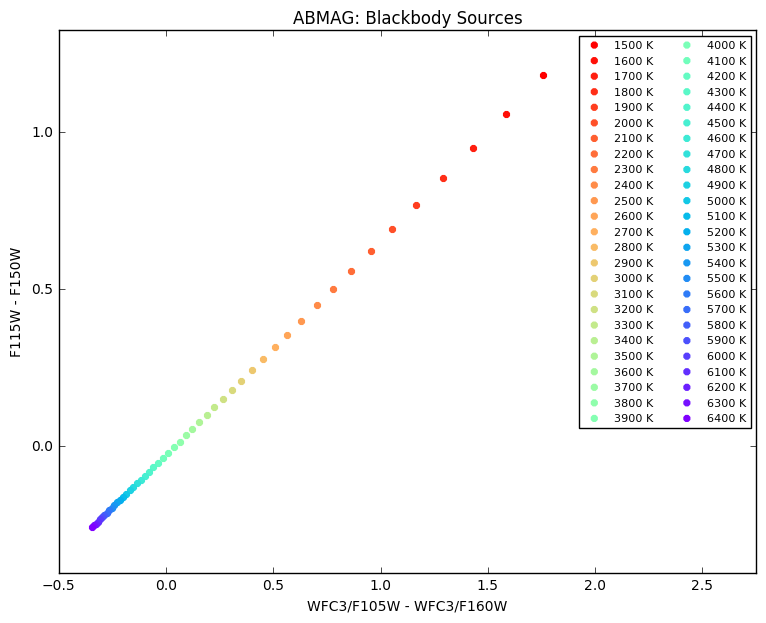

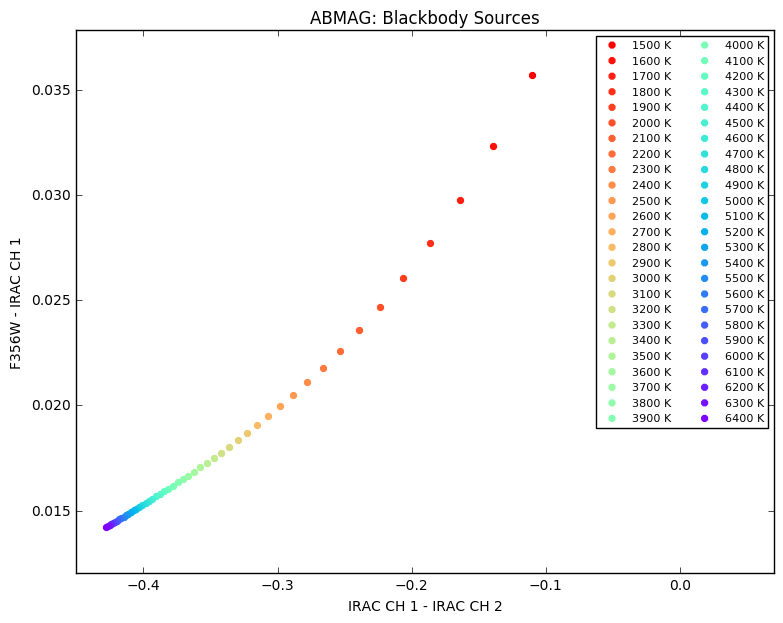

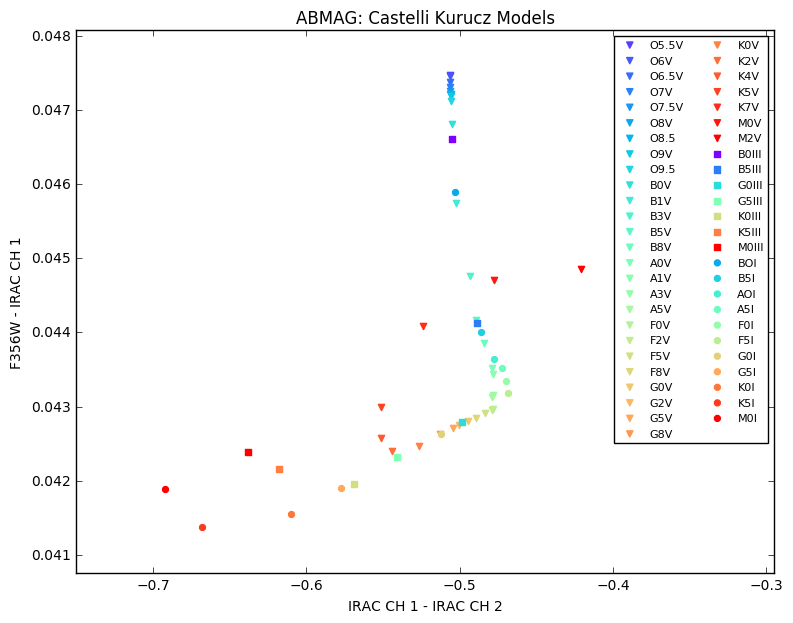

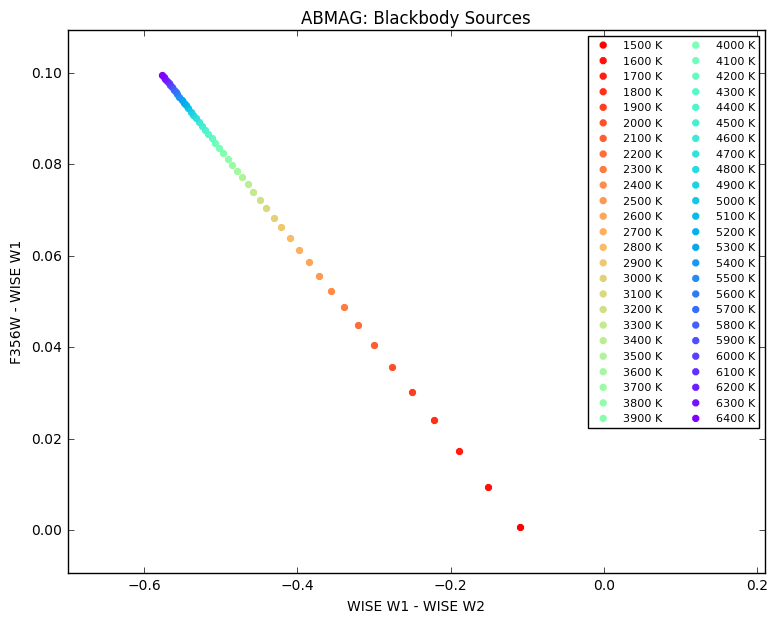

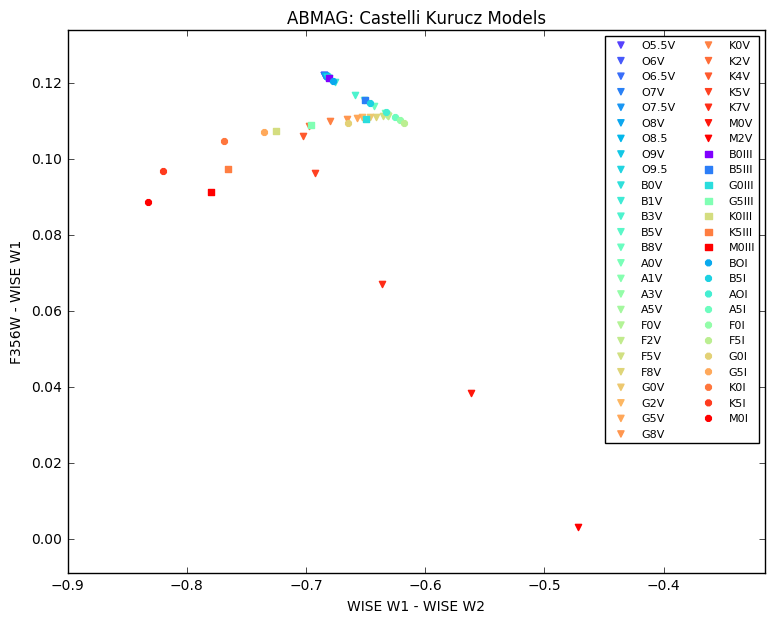

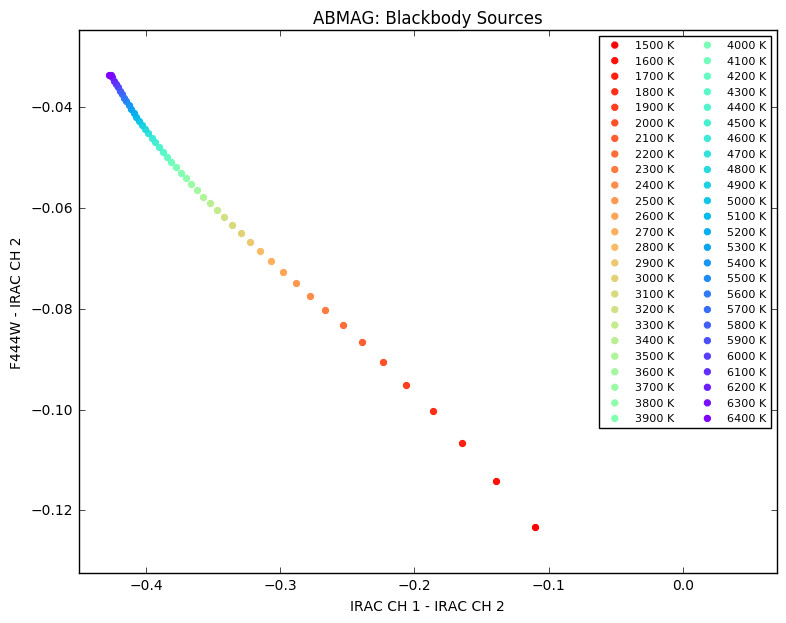

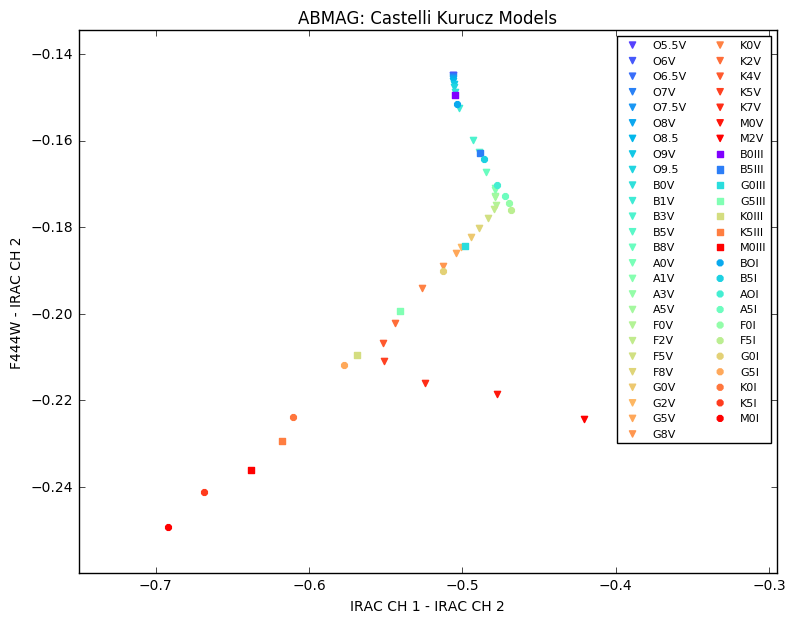

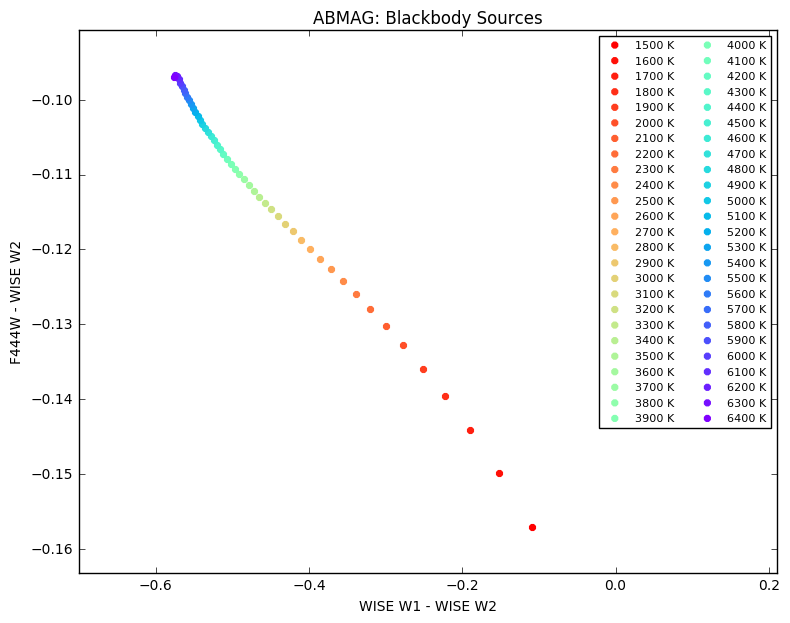

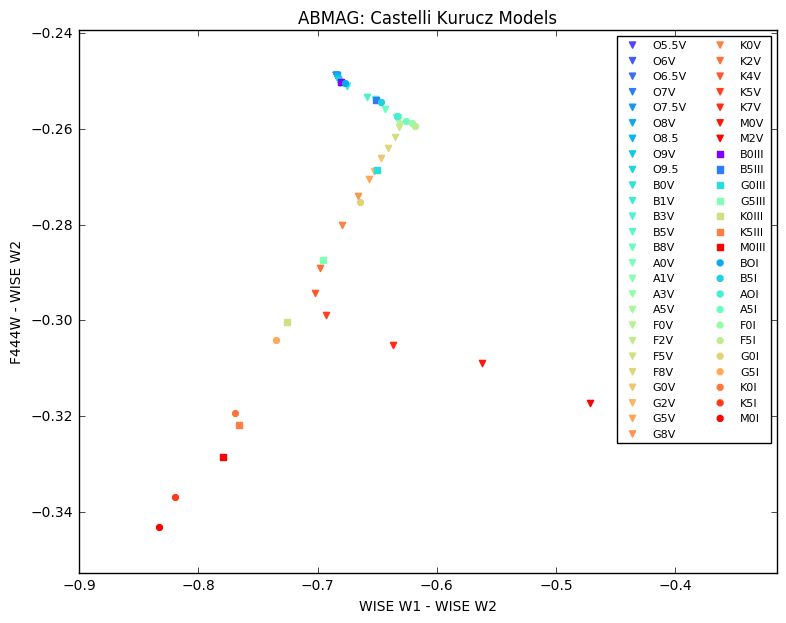

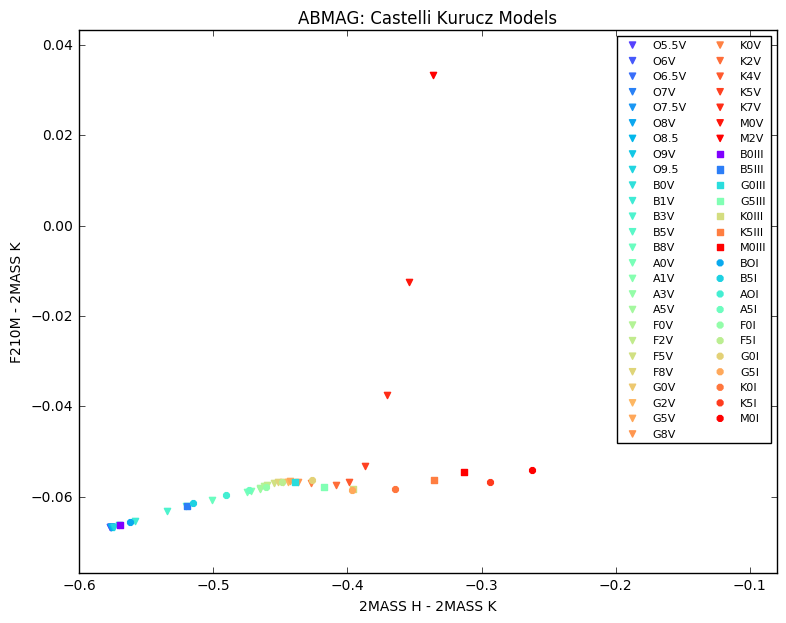

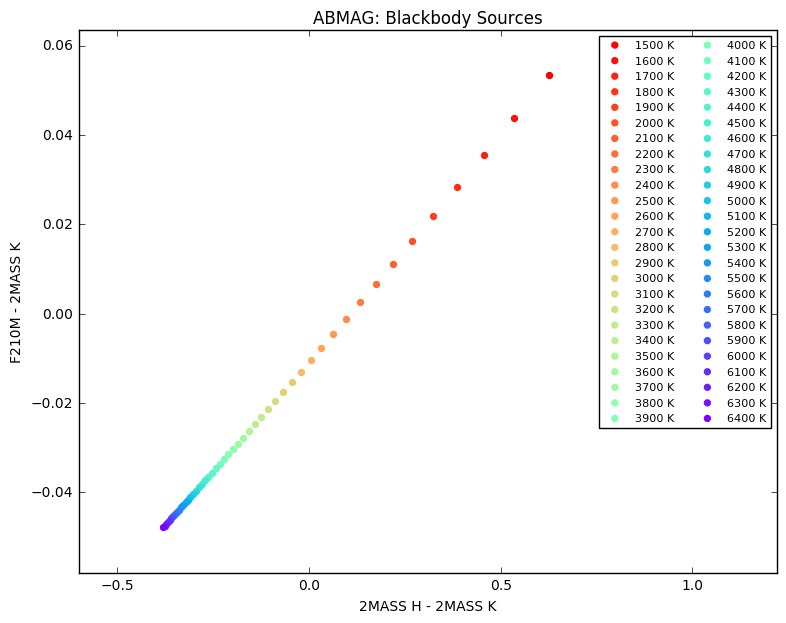

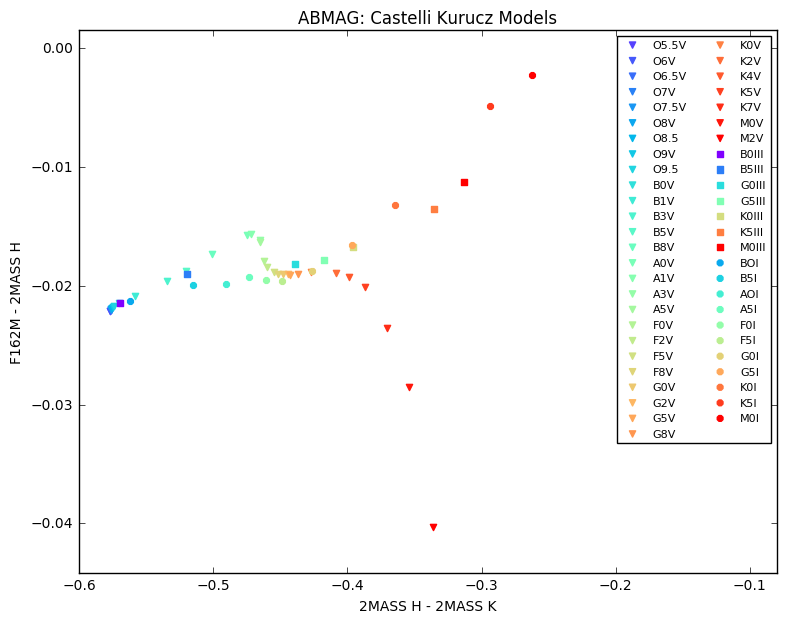

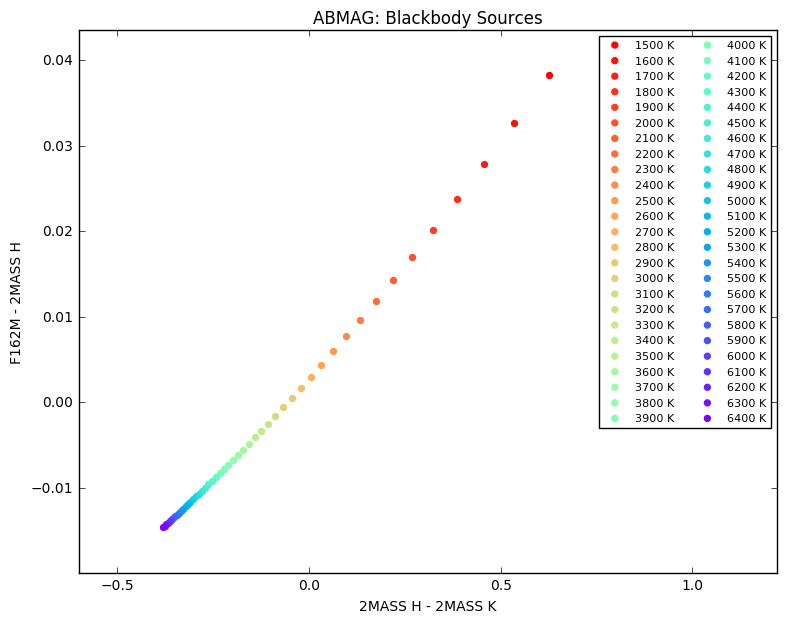

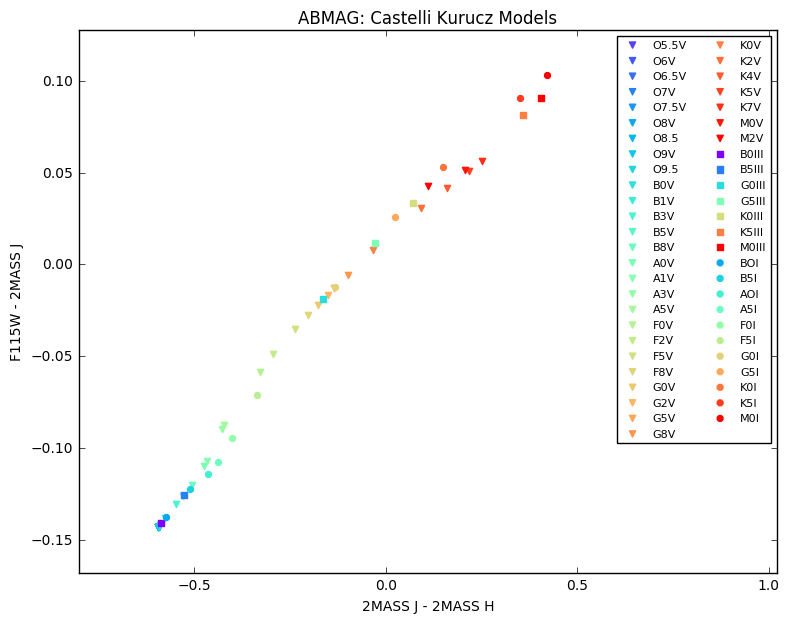

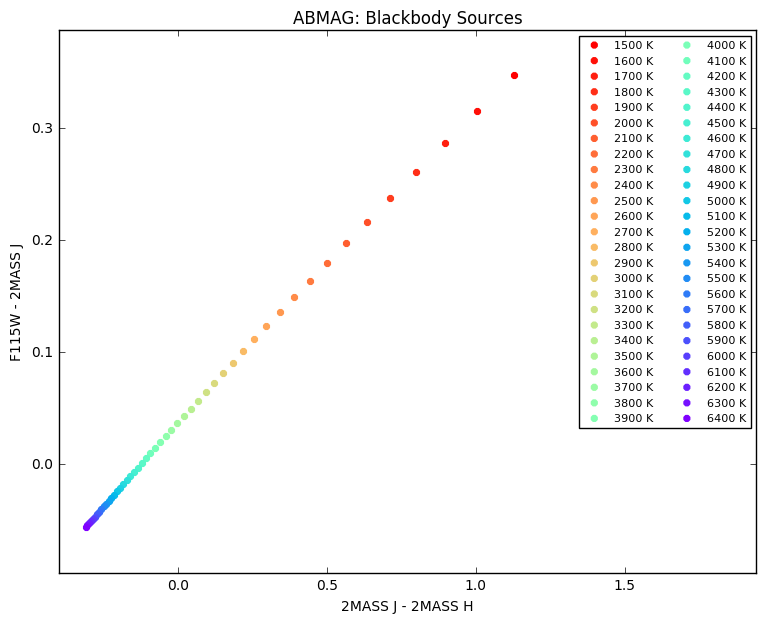

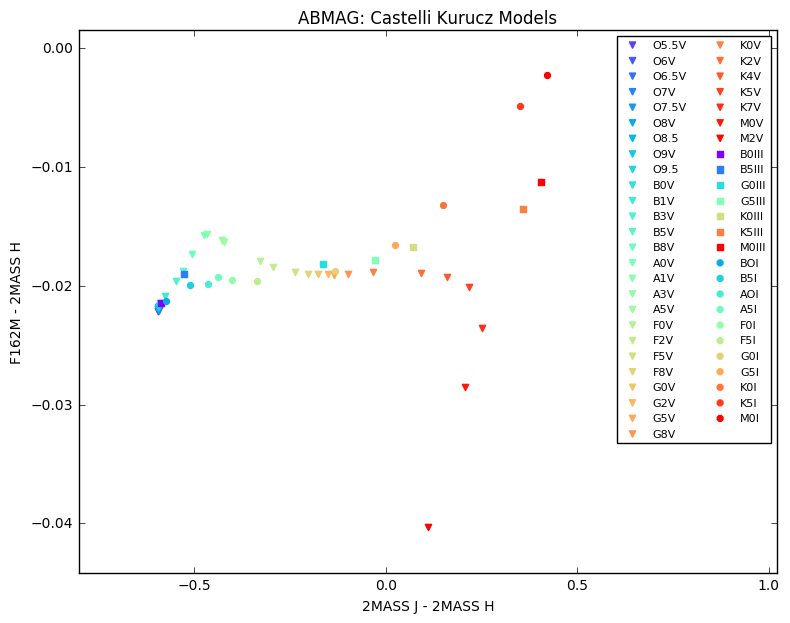

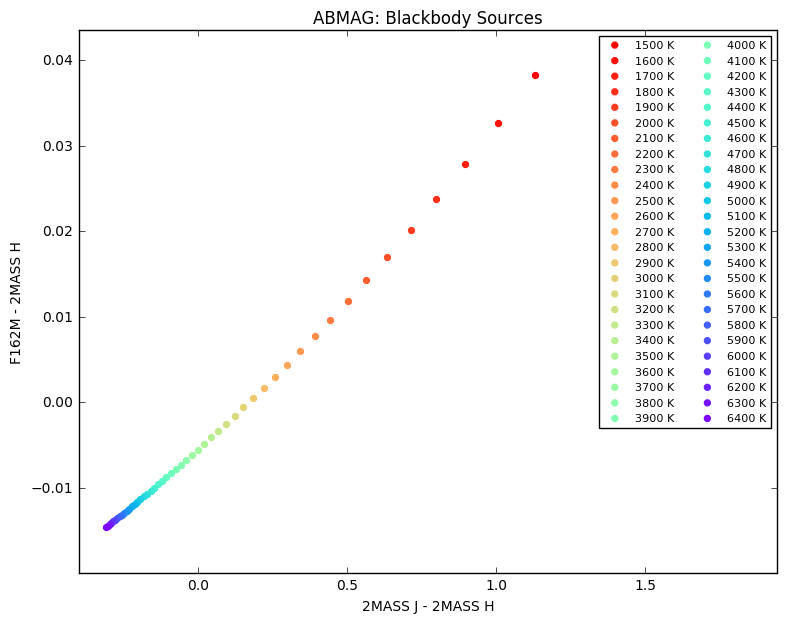

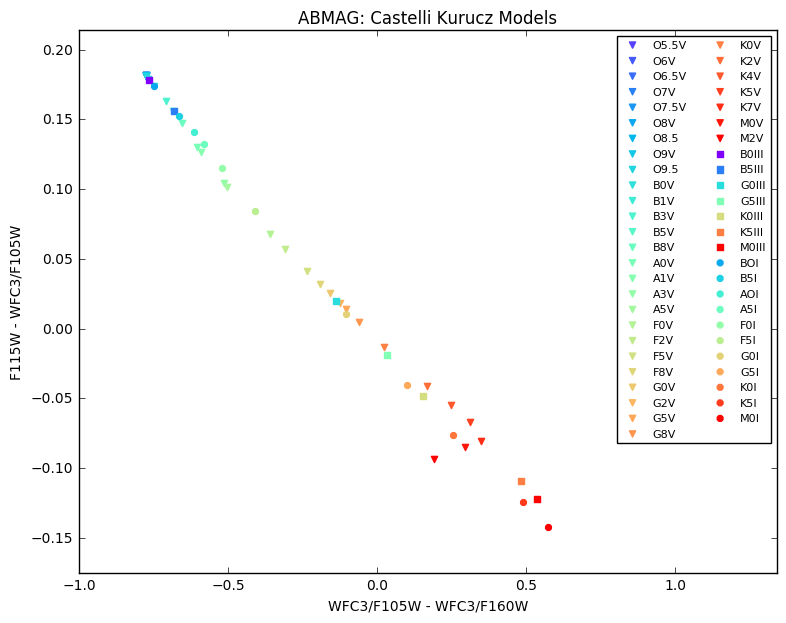

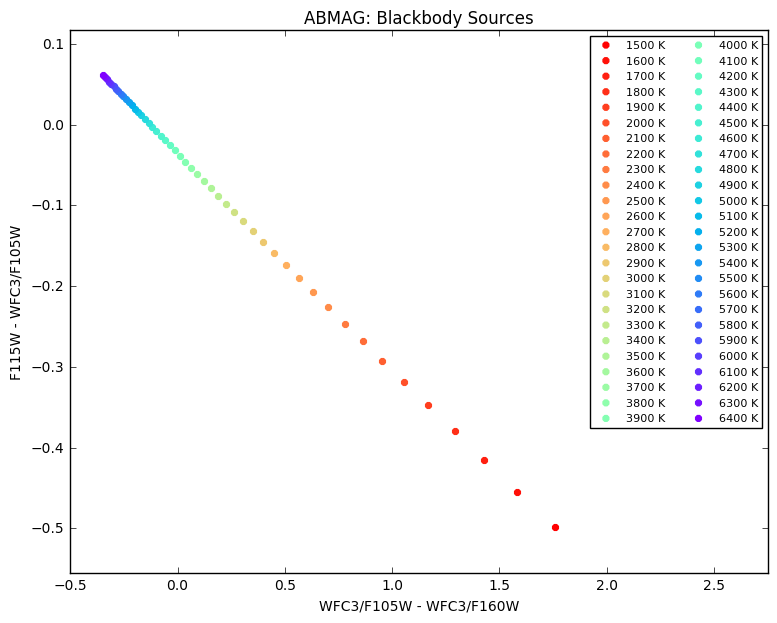

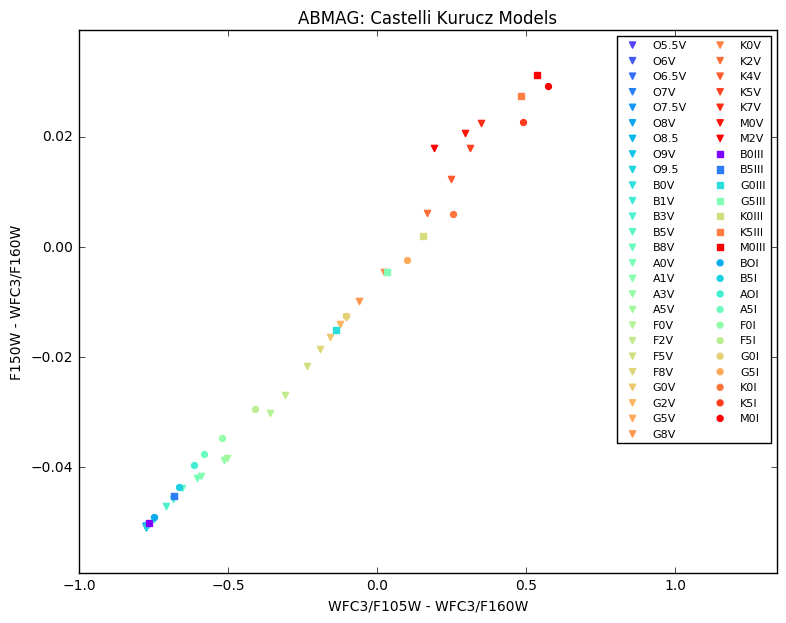

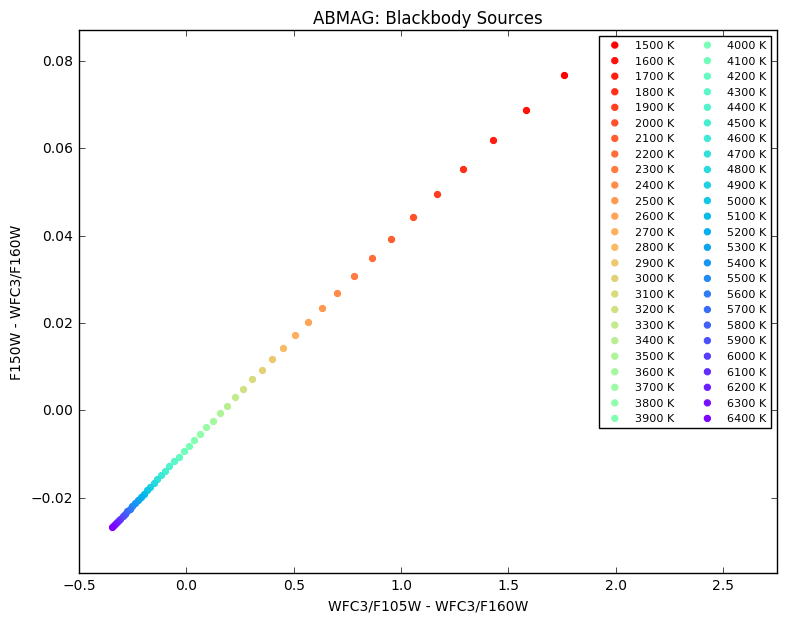

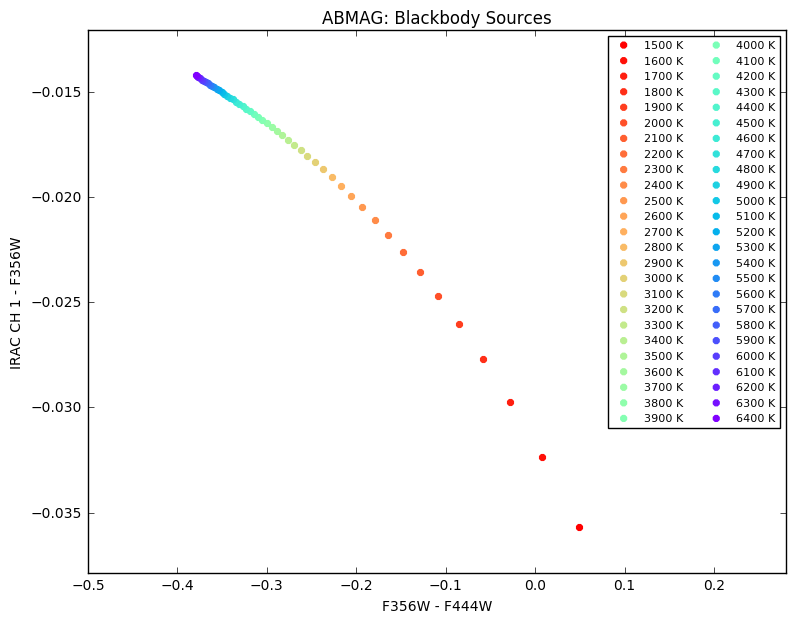

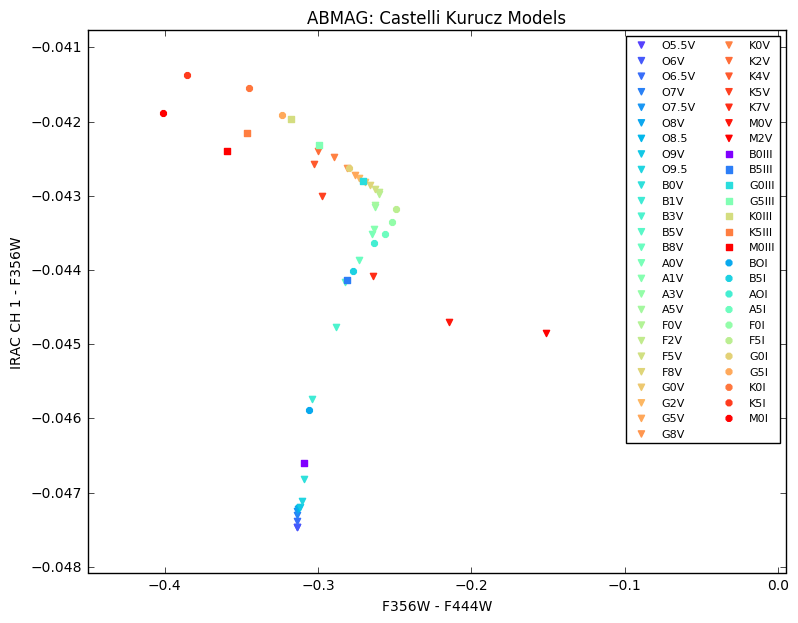

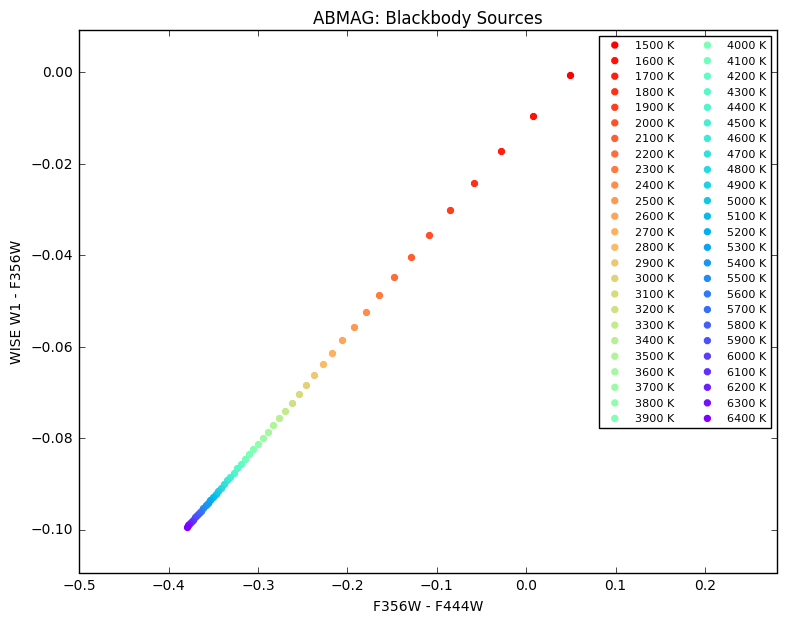

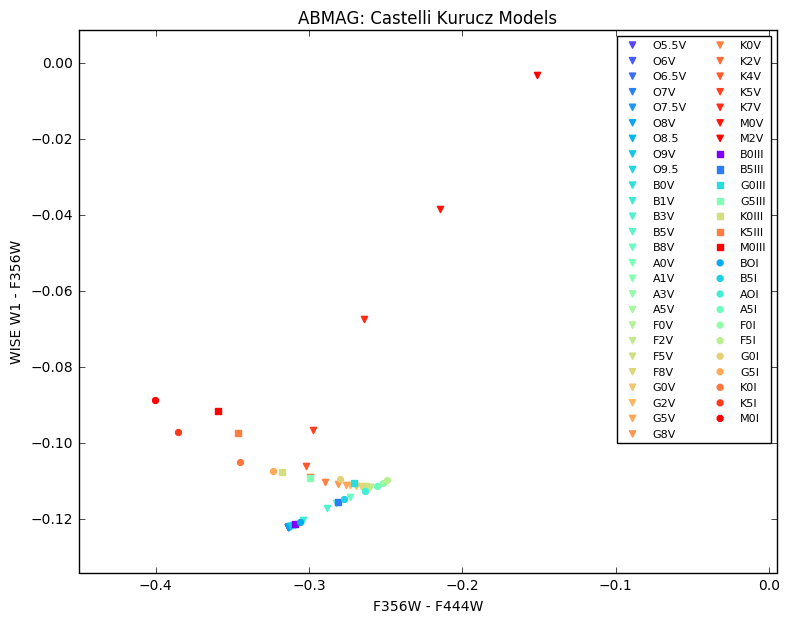

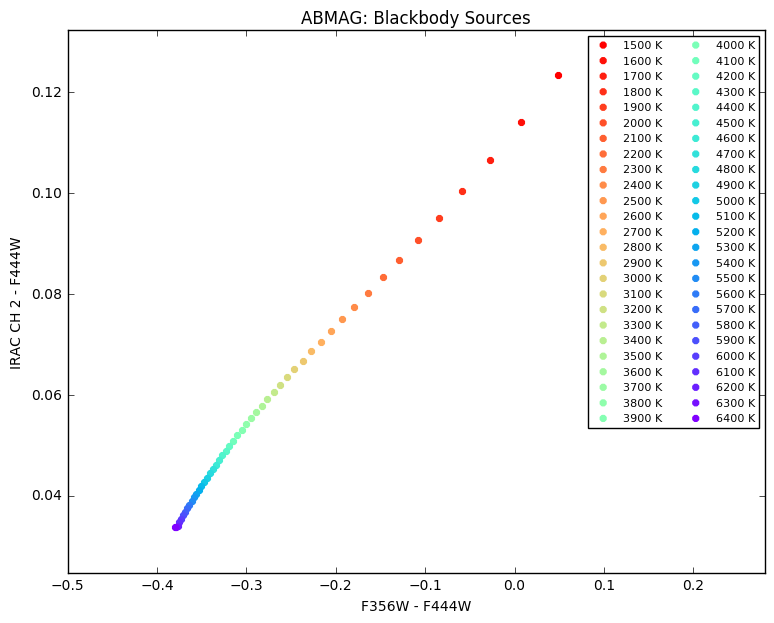

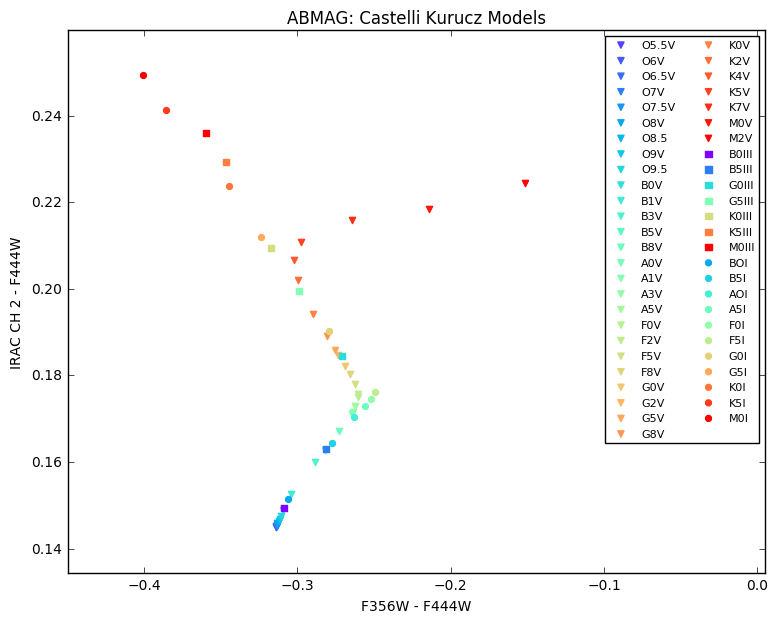

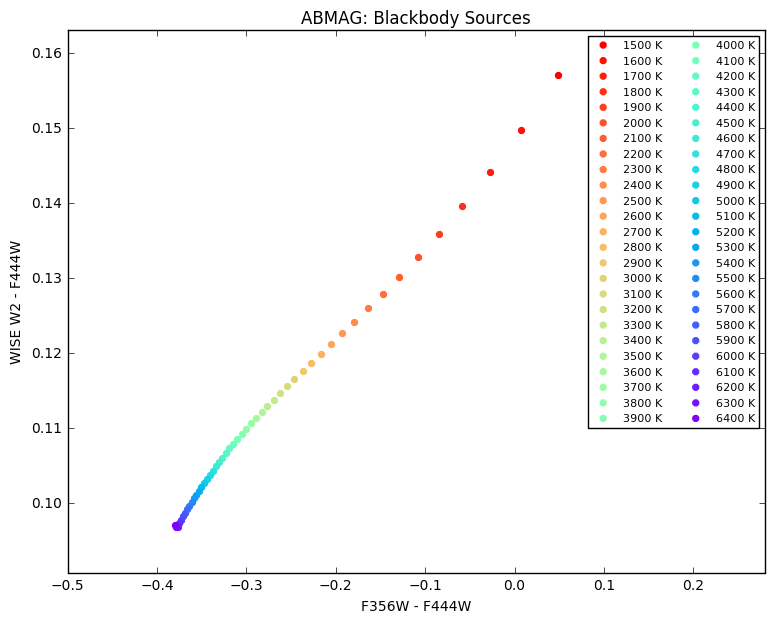

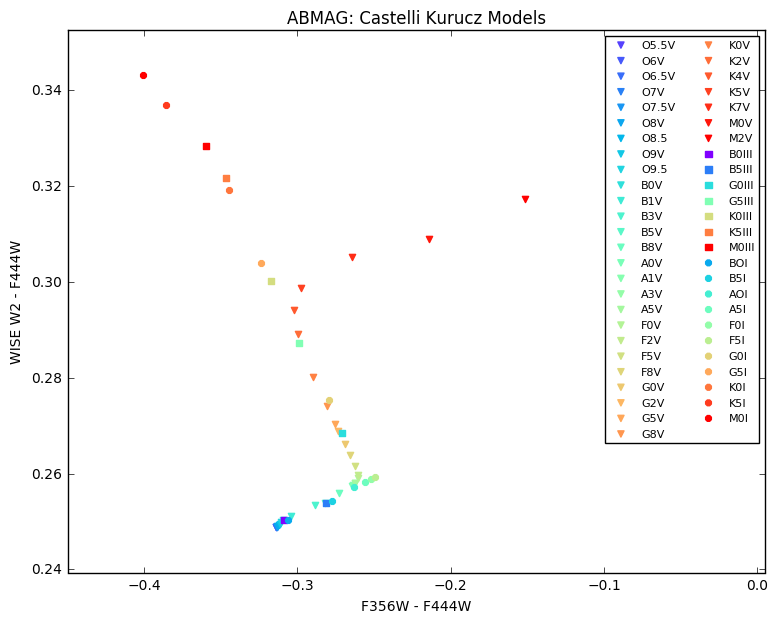

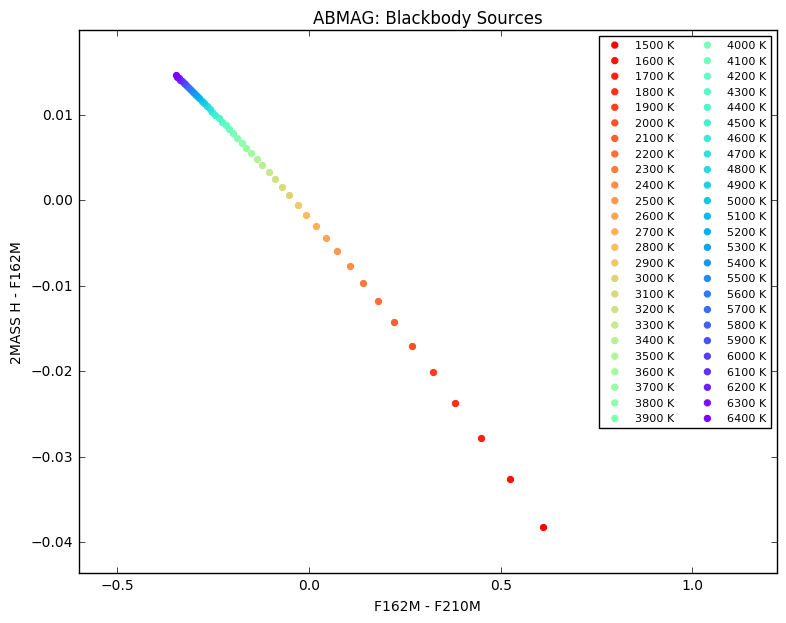

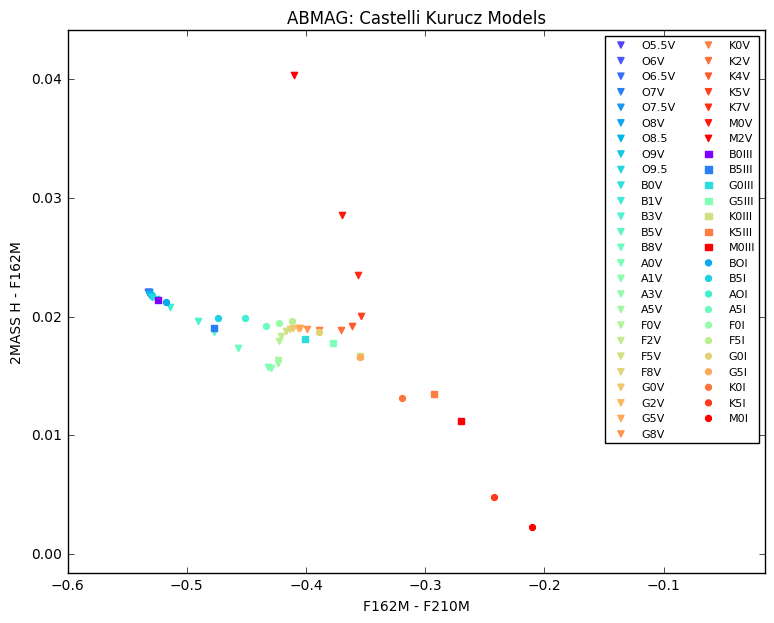

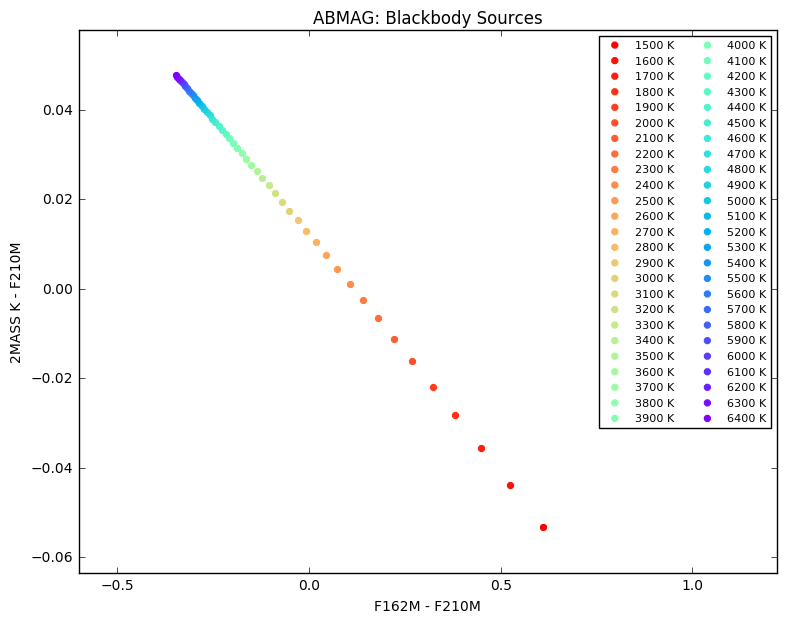

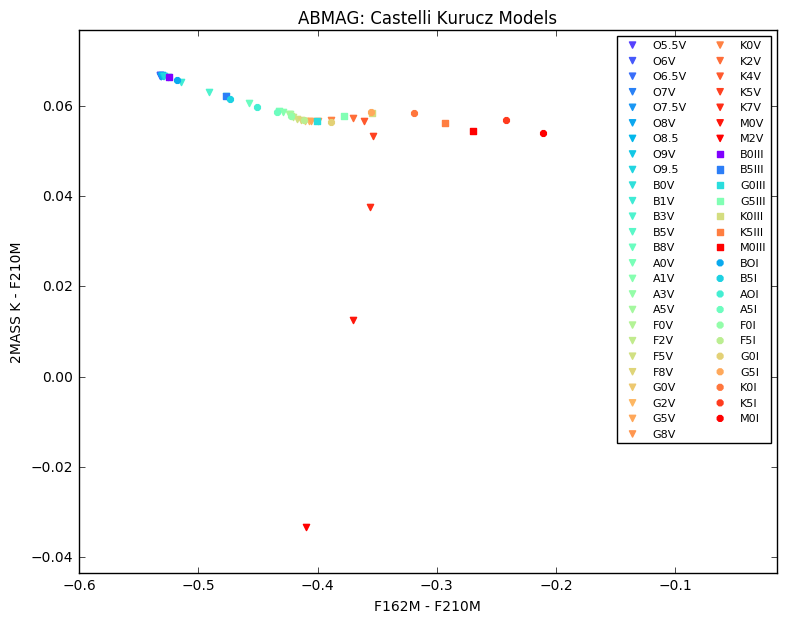

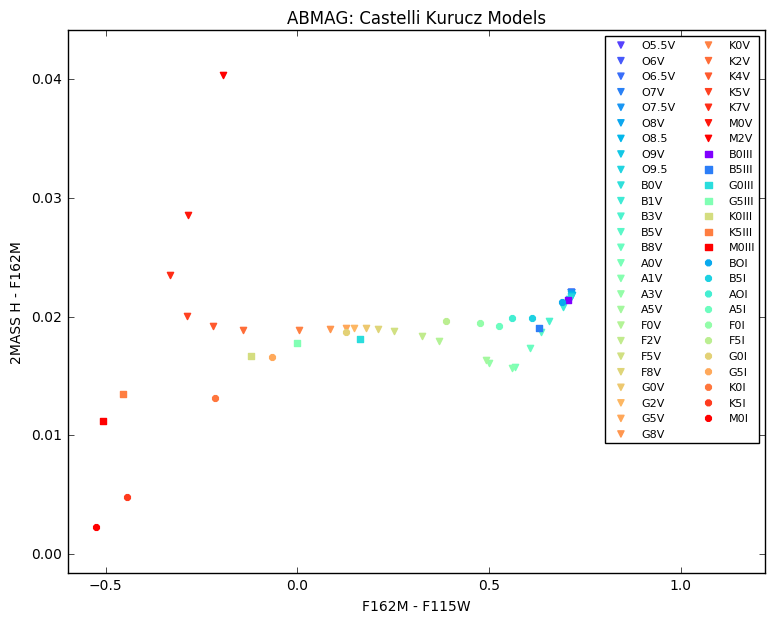

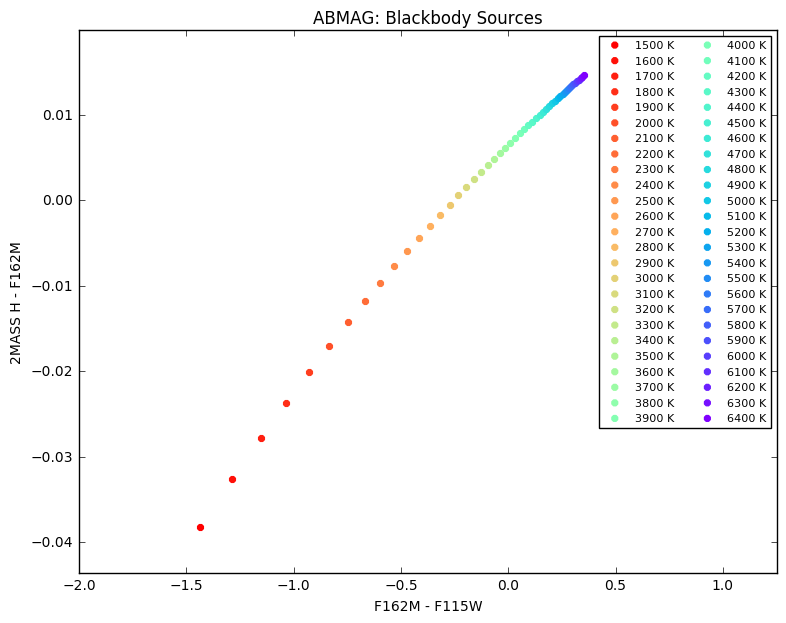

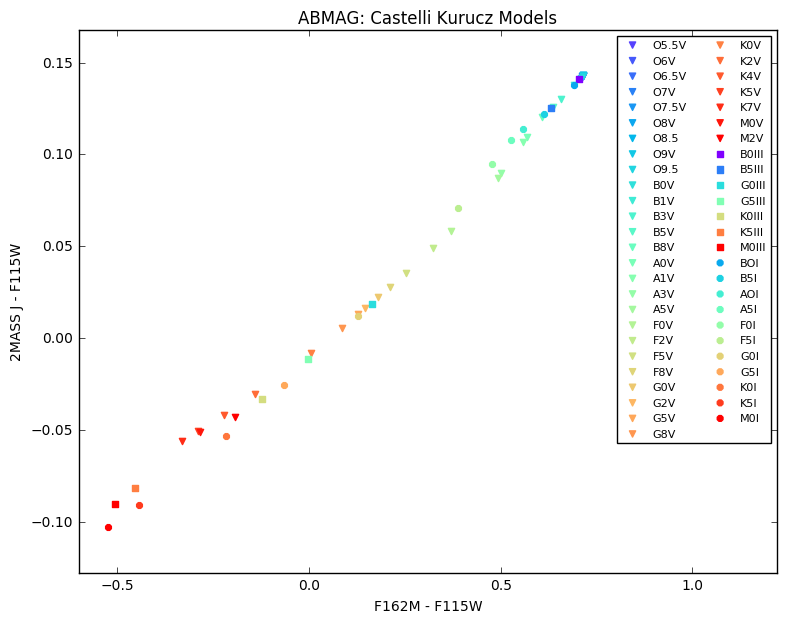

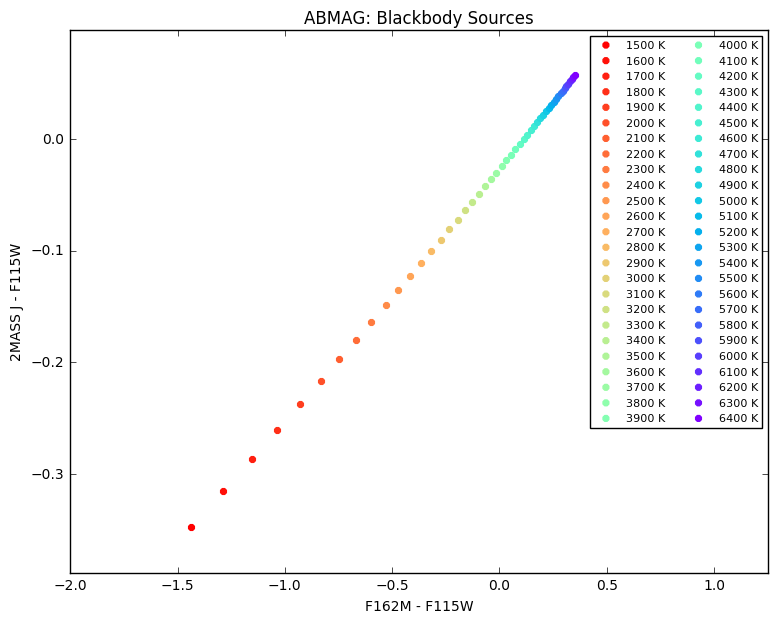

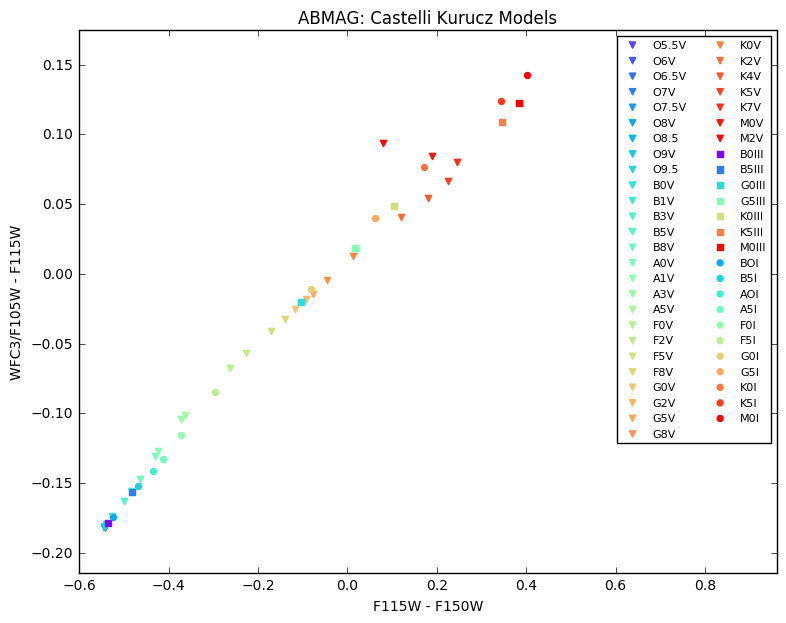

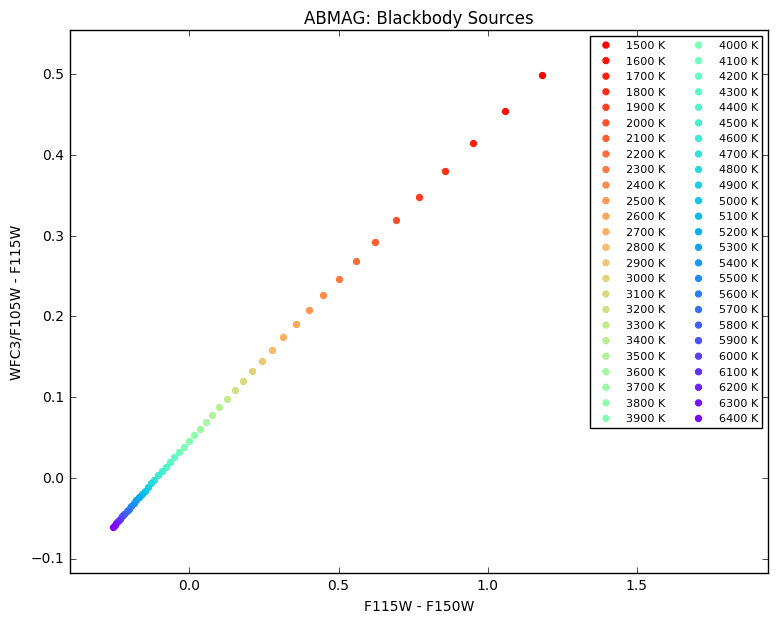

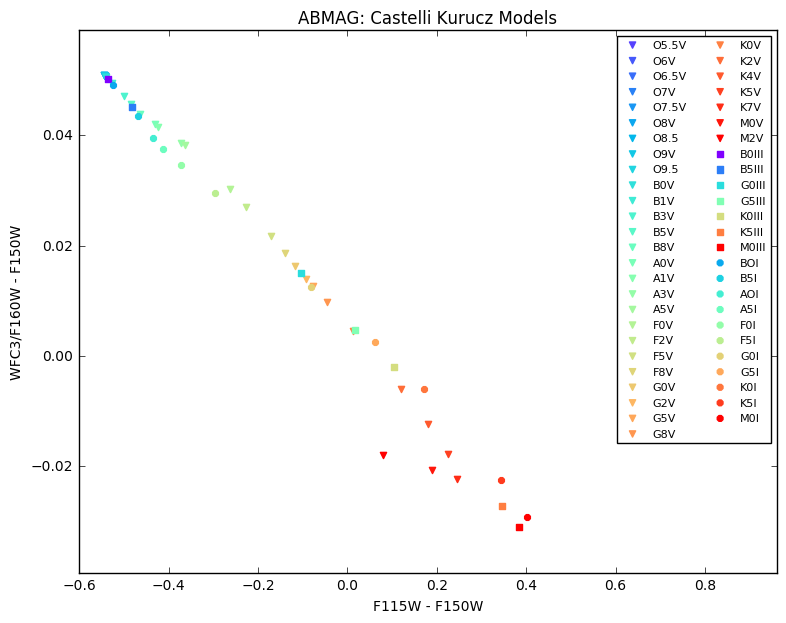

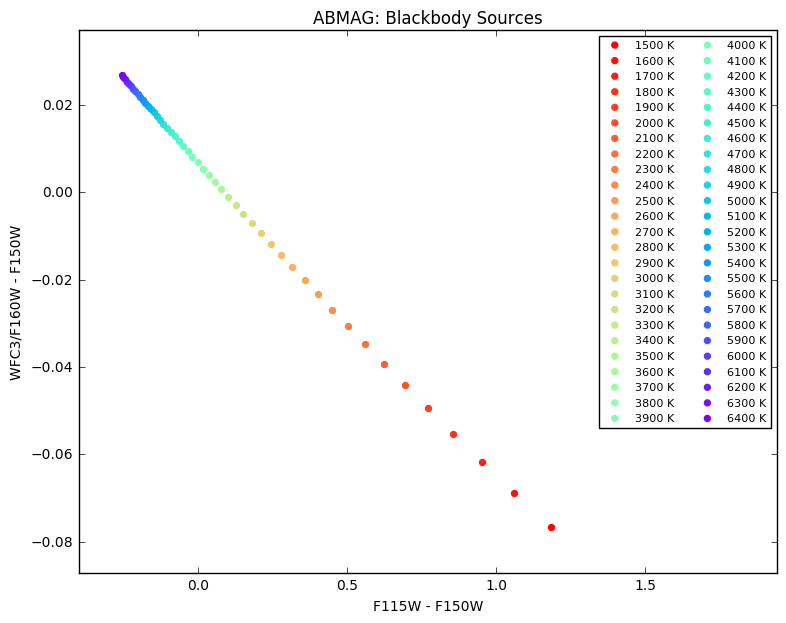

In [27]:
# Create all plots of interest

# deltamag plots for blackbody sources only
deltamag(nrc_bb_mags['f090w'],wfc3_bb_mags['f098m'],'F090W','WFC3/F098M',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f140m'],wfc3_bb_mags['f139m'],'F140M','WFC3/F139M',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f150w'],wfc3_bb_mags['f140w'],'F150W','WFC3/F140W',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f150w'],wfc3_bb_mags['f160w'],'F150W','WFC3/F160W',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f090w'],wfc3_bb_mags['f098m'],'F090W','WFC3/F098M',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f115w'],wfc3_bb_mags['f105w'],'F115W','WFC3/F105W',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f115w'],wfc3_bb_mags['f125w'],'F115W','WFC3/F125W',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f115w'],other_bb_mags['2massj'],'F115W','2MASS J',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f162m'],other_bb_mags['2massh'],'F162M','2MASS H',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f210m'],other_bb_mags['2massk'],'F210M','2MASS K',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f356w'],other_bb_mags['irac1'],'F356W','IRAC Ch 1',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f444w'],other_bb_mags['irac2'],'F444W','IRAC Ch 2',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f356w'],other_bb_mags['wise1'],'F356W','WISE W1',bb_temps,'blackbody','abmag')
deltamag(nrc_bb_mags['f444w'],other_bb_mags['wise2'],'F444W','WISE W2',bb_temps,'blackbody','abmag')

# color color plots

# 2 nircam filters, 2 other filters
colorcolor(other_stellar_mags['irac1'],other_stellar_mags['irac2'],nrc_stellar_mags['f356w'],nrc_stellar_mags['f444w'],'IRAC Ch 1','IRAC Ch 2','F356W','F444W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['irac1'],other_bb_mags['irac2'],nrc_bb_mags['f356w'],nrc_bb_mags['f444w'],'IRAC Ch 1','IRAC Ch 2','F356W','F444W',bb_temps,'abmag','Blackbody Sources')
colorcolor(other_stellar_mags['wise1'],other_stellar_mags['wise2'],nrc_stellar_mags['f356w'],nrc_stellar_mags['f444w'],'WISE W1','WISE W2','F356W','F444W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['wise1'],other_bb_mags['wise2'],nrc_bb_mags['f356w'],nrc_bb_mags['f444w'],'WISE W1','WISE W2','F356W','F444W',bb_temps,'abmag','Blackbody Sources')
colorcolor(other_stellar_mags['2massh'],other_stellar_mags['2massk'],nrc_stellar_mags['f162m'],nrc_stellar_mags['f210m'],'2MASS H','2MASS K','F162M','F210M',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['2massh'],other_bb_mags['2massk'],nrc_bb_mags['f162m'],nrc_bb_mags['f210m'],'2MASS H','2MASS K','F162M','F210M',bb_temps,'abmag','Blackbody Sources')
colorcolor(other_stellar_mags['2massj'],other_stellar_mags['2massh'],nrc_stellar_mags['f115w'],nrc_stellar_mags['f162m'],'2MASS J','2MASS H','F115W','F162M',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['2massj'],other_bb_mags['2massh'],nrc_bb_mags['f115w'],nrc_bb_mags['f162m'],'2MASS J','2MASS H','F115W','F162M',bb_temps,'abmag','Blackbody Sources')
colorcolor(wfc3_stellar_mags['f105w'],wfc3_stellar_mags['f160w'],nrc_stellar_mags['f115w'],nrc_stellar_mags['f150w'],'WFC3/F105W','WFC3/F160W','F115W','F150W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(wfc3_bb_mags['f105w'],wfc3_bb_mags['f160w'],nrc_bb_mags['f115w'],nrc_bb_mags['f150w'],'WFC3/F105W','WFC3/F160W','F115W','F150W',bb_temps,'abmag','Blackbody Sources')

# 1 nircam filter, 2 other filters
colorcolor(other_bb_mags['irac1'],other_bb_mags['irac2'],nrc_bb_mags['f356w'],other_bb_mags['irac1'],'IRAC Ch 1','IRAC Ch 2','F356W','IRAC Ch 1',bb_temps,'abmag','Blackbody Sources')
colorcolor(other_stellar_mags['irac1'],other_stellar_mags['irac2'],nrc_stellar_mags['f356w'],other_stellar_mags['irac1'],'IRAC Ch 1','IRAC Ch 2','F356W','IRAC Ch 1',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['wise1'],other_bb_mags['wise2'],nrc_bb_mags['f356w'],other_bb_mags['wise1'],'WISE W1','WISE W2','F356W','WISE W1',bb_temps,'abmag','Blackbody Sources')
colorcolor(other_stellar_mags['wise1'],other_stellar_mags['wise2'],nrc_stellar_mags['f356w'],other_stellar_mags['wise1'],'WISE W1','WISE W2','F356W','WISE W1',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['irac1'],other_bb_mags['irac2'],nrc_bb_mags['f444w'],other_bb_mags['irac2'],'IRAC Ch 1','IRAC Ch 2','F444W','IRAC Ch 2',bb_temps,'abmag','Blackbody Sources')
colorcolor(other_stellar_mags['irac1'],other_stellar_mags['irac2'],nrc_stellar_mags['f444w'],other_stellar_mags['irac2'],'IRAC Ch 1','IRAC Ch 2','F444W','IRAC Ch 2',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['wise1'],other_bb_mags['wise2'],nrc_bb_mags['f444w'],other_bb_mags['wise2'],'WISE W1','WISE W2','F444W','WISE W2',bb_temps,'abmag','Blackbody Sources')
colorcolor(other_stellar_mags['wise1'],other_stellar_mags['wise2'],nrc_stellar_mags['f444w'],other_stellar_mags['wise2'],'WISE W1','WISE W2','F444W','WISE W2',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_stellar_mags['2massh'],other_stellar_mags['2massk'],nrc_stellar_mags['f210m'],other_stellar_mags['2massk'],'2MASS H','2MASS K','F210M','2MASS K',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['2massh'],other_bb_mags['2massk'],nrc_bb_mags['f210m'],other_bb_mags['2massk'],'2MASS H','2MASS K','F210M','2MASS K',bb_temps,'abmag','Blackbody Sources')
colorcolor(other_stellar_mags['2massh'],other_stellar_mags['2massk'],nrc_stellar_mags['f162m'],other_stellar_mags['2massh'],'2MASS H','2MASS K','F162M','2MASS H',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['2massh'],other_bb_mags['2massk'],nrc_bb_mags['f162m'],other_bb_mags['2massh'],'2MASS H','2MASS K','F162M','2MASS H',bb_temps,'abmag','Blackbody Sources')
colorcolor(other_stellar_mags['2massj'],other_stellar_mags['2massh'],nrc_stellar_mags['f115w'],other_stellar_mags['2massj'],'2MASS J','2MASS H','F115W','2MASS J',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['2massj'],other_bb_mags['2massh'],nrc_bb_mags['f115w'],other_bb_mags['2massj'],'2MASS J','2MASS H','F115W','2MASS J',bb_temps,'abmag','Blackbody Sources')
colorcolor(other_stellar_mags['2massj'],other_stellar_mags['2massh'],nrc_stellar_mags['f162m'],other_stellar_mags['2massh'],'2MASS J','2MASS H','F162M','2MASS H',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(other_bb_mags['2massj'],other_bb_mags['2massh'],nrc_bb_mags['f162m'],other_bb_mags['2massh'],'2MASS J','2MASS H','F162M','2MASS H',bb_temps,'abmag','Blackbody Sources')
colorcolor(wfc3_stellar_mags['f105w'],wfc3_stellar_mags['f160w'],nrc_stellar_mags['f115w'],wfc3_stellar_mags['f105w'],'WFC3/F105W','WFC3/F160W','F115W','WFC3/F105W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(wfc3_bb_mags['f105w'],wfc3_bb_mags['f160w'],nrc_bb_mags['f115w'],wfc3_bb_mags['f105w'],'WFC3/F105W','WFC3/F160W','F115W','WFC3/F105W',bb_temps,'abmag','Blackbody Sources')
colorcolor(wfc3_stellar_mags['f105w'],wfc3_stellar_mags['f160w'],nrc_stellar_mags['f150w'],wfc3_stellar_mags['f160w'],'WFC3/F105W','WFC3/F160W','F150W','WFC3/F160W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(wfc3_bb_mags['f105w'],wfc3_bb_mags['f160w'],nrc_bb_mags['f150w'],wfc3_bb_mags['f160w'],'WFC3/F105W','WFC3/F160W','F150W','WFC3/F160W',bb_temps,'abmag','Blackbody Sources')

# opposite of cases just above. Those are plotted versus other instrument's color.
# These are plotted versus NIRCam color.
colorcolor(nrc_bb_mags['f356w'],nrc_bb_mags['f444w'],other_bb_mags['irac1'],nrc_bb_mags['f356w'],'F356W','F444W','IRAC Ch 1','F356W',bb_temps,'abmag','Blackbody Sources')
colorcolor(nrc_stellar_mags['f356w'],nrc_stellar_mags['f444w'],other_stellar_mags['irac1'],nrc_stellar_mags['f356w'],'F356W','F444W','IRAC Ch 1','F356W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(nrc_bb_mags['f356w'],nrc_bb_mags['f444w'],other_bb_mags['wise1'],nrc_bb_mags['f356w'],'F356W','F444W','WISE W1','F356W',bb_temps,'abmag','Blackbody Sources')
colorcolor(nrc_stellar_mags['f356w'],nrc_stellar_mags['f444w'],other_stellar_mags['wise1'],nrc_stellar_mags['f356w'],'F356W','F444W','WISE W1','F356W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(nrc_bb_mags['f356w'],nrc_bb_mags['f444w'],other_bb_mags['irac2'],nrc_bb_mags['f444w'],'F356W','F444W','IRAC Ch 2','F444W',bb_temps,'abmag','Blackbody Sources')
colorcolor(nrc_stellar_mags['f356w'],nrc_stellar_mags['f444w'],other_stellar_mags['irac2'],nrc_stellar_mags['f444w'],'F356W','F444W','IRAC Ch 2','F444W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(nrc_bb_mags['f356w'],nrc_bb_mags['f444w'],other_bb_mags['wise2'],nrc_bb_mags['f444w'],'F356W','F444W','WISE W2','F444W',bb_temps,'abmag','Blackbody Sources')
colorcolor(nrc_stellar_mags['f356w'],nrc_stellar_mags['f444w'],other_stellar_mags['wise2'],nrc_stellar_mags['f444w'],'F356W','F444W','WISE W2','F444W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(nrc_bb_mags['f162m'],nrc_bb_mags['f210m'],other_bb_mags['2massh'],nrc_bb_mags['f162m'],'F162M','F210M','2MASS H','F162M',bb_temps,'abmag','Blackbody Sources')
colorcolor(nrc_stellar_mags['f162m'],nrc_stellar_mags['f210m'],other_stellar_mags['2massh'],nrc_stellar_mags['f162m'],'F162M','F210M','2MASS H','F162M',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(nrc_bb_mags['f162m'],nrc_bb_mags['f210m'],other_bb_mags['2massk'],nrc_bb_mags['f210m'],'F162M','F210M','2MASS K','F210M',bb_temps,'abmag','Blackbody Sources')
colorcolor(nrc_stellar_mags['f162m'],nrc_stellar_mags['f210m'],other_stellar_mags['2massk'],nrc_stellar_mags['f210m'],'F162M','F210M','2MASS K','F210M',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(nrc_stellar_mags['f162m'],nrc_stellar_mags['f115w'],other_stellar_mags['2massh'],nrc_stellar_mags['f162m'],'F162M','F115W','2MASS H','F162M',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(nrc_bb_mags['f162m'],nrc_bb_mags['f115w'],other_bb_mags['2massh'],nrc_bb_mags['f162m'],'F162M','F115W','2MASS H','F162M',bb_temps,'abmag','Blackbody Sources')
colorcolor(nrc_stellar_mags['f162m'],nrc_stellar_mags['f115w'],other_stellar_mags['2massj'],nrc_stellar_mags['f115w'],'F162M','F115W','2MASS J','F115W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(nrc_bb_mags['f162m'],nrc_bb_mags['f115w'],other_bb_mags['2massj'],nrc_bb_mags['f115w'],'F162M','F115W','2MASS J','F115W',bb_temps,'abmag','Blackbody Sources')
colorcolor(nrc_stellar_mags['f115w'],nrc_stellar_mags['f150w'],wfc3_stellar_mags['f105w'],nrc_stellar_mags['f115w'],'F115W','F150W','WFC3/F105W','F115W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(nrc_bb_mags['f115w'],nrc_bb_mags['f150w'],wfc3_bb_mags['f105w'],nrc_bb_mags['f115w'],'F115W','F150W','WFC3/F105W','F115W',bb_temps,'abmag','Blackbody Sources')
colorcolor(nrc_stellar_mags['f115w'],nrc_stellar_mags['f150w'],wfc3_stellar_mags['f160w'],nrc_stellar_mags['f150w'],'F115W','F150W','WFC3/F160W','F150W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(nrc_bb_mags['f115w'],nrc_bb_mags['f150w'],wfc3_bb_mags['f160w'],nrc_bb_mags['f150w'],'F115W','F150W','WFC3/F160W','F150W',bb_temps,'abmag','Blackbody Sources')

In [50]:
bb_temps

array([1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500,
       2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600,
       3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700,
       4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800,
       5900, 6000, 6100, 6200, 6300, 6400])

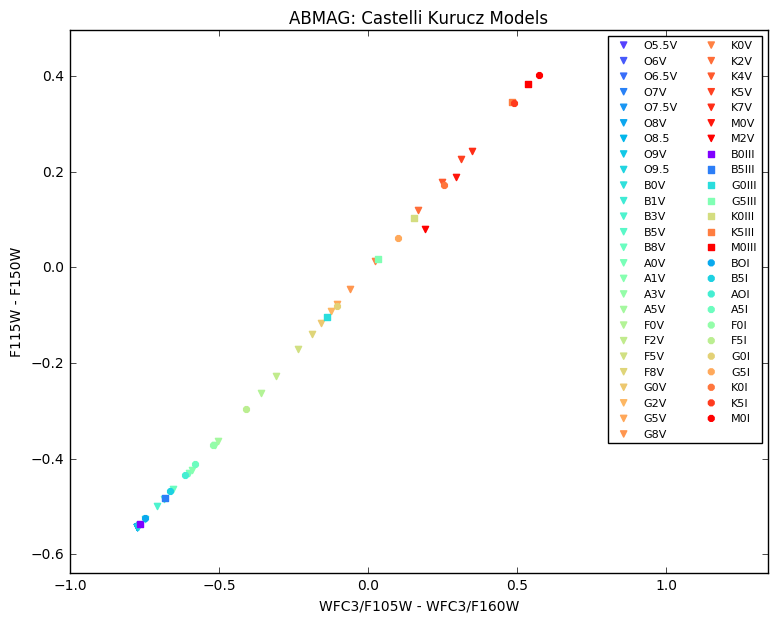

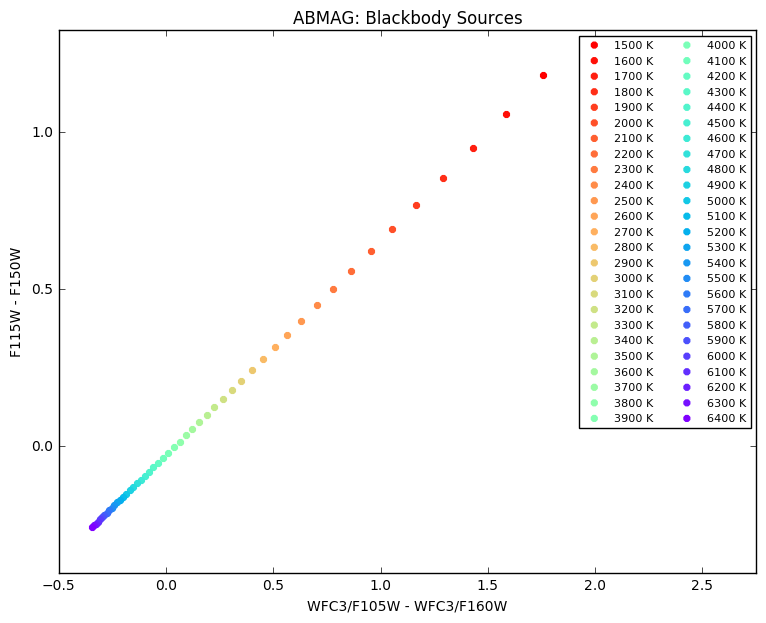

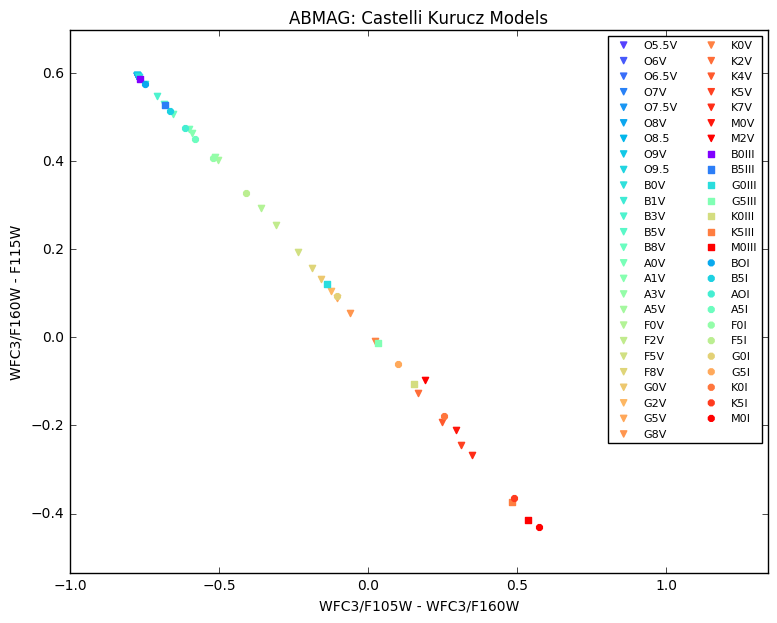

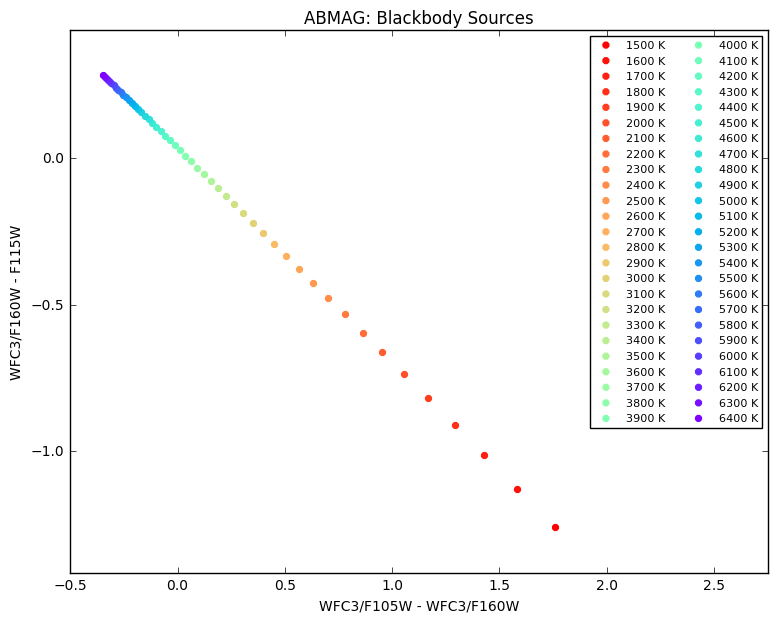

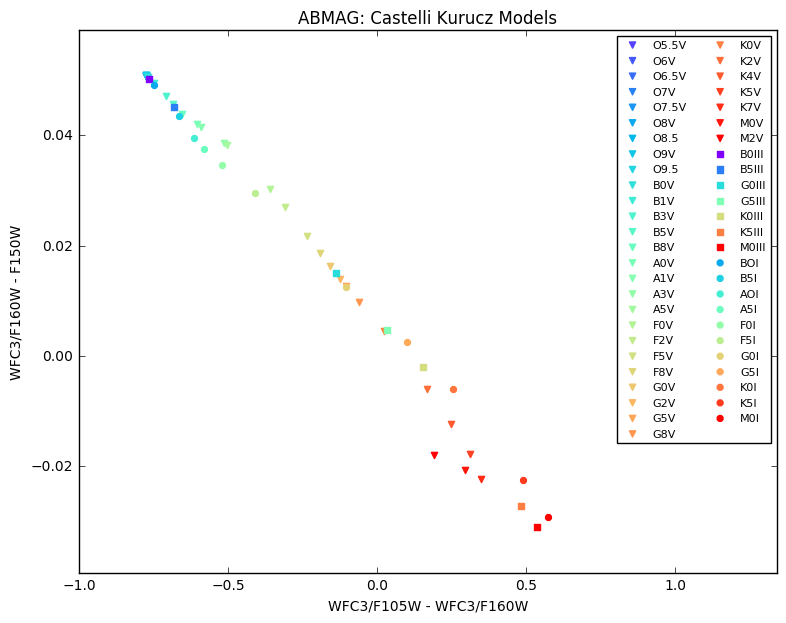

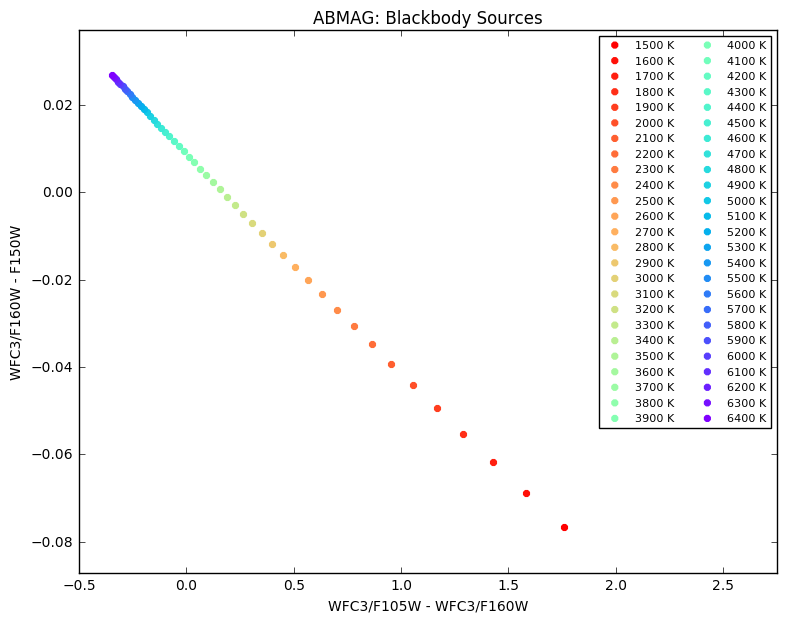

In [51]:
colorcolor(wfc3_stellar_mags['f105w'],wfc3_stellar_mags['f160w'],nrc_stellar_mags['f115w'],nrc_stellar_mags['f150w'],'WFC3/F105W','WFC3/F160W','F115W','F150W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(wfc3_bb_mags['f105w'],wfc3_bb_mags['f160w'],nrc_bb_mags['f115w'],nrc_bb_mags['f150w'],'WFC3/F105W','WFC3/F160W','F115W','F150W',bb_temps,'abmag','Blackbody Sources')
colorcolor(wfc3_stellar_mags['f105w'],wfc3_stellar_mags['f160w'],wfc3_stellar_mags['f160w'],nrc_stellar_mags['f115w'],'WFC3/F105W','WFC3/F160W','WFC3/F160W','F115W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(wfc3_bb_mags['f105w'],wfc3_bb_mags['f160w'],wfc3_bb_mags['f160w'],nrc_bb_mags['f115w'],'WFC3/F105W','WFC3/F160W','WFC3/F160W','F115W',bb_temps,'abmag','Blackbody Sources')
colorcolor(wfc3_stellar_mags['f105w'],wfc3_stellar_mags['f160w'],wfc3_stellar_mags['f160w'],nrc_stellar_mags['f150w'],'WFC3/F105W','WFC3/F160W','WFC3/F160W','F150W',stellar_type,'abmag','Castelli Kurucz Models')
colorcolor(wfc3_bb_mags['f105w'],wfc3_bb_mags['f160w'],wfc3_bb_mags['f160w'],nrc_bb_mags['f150w'],'WFC3/F105W','WFC3/F160W','WFC3/F160W','F150W',bb_temps,'abmag','Blackbody Sources')